In [1]:
from IPython.display import HTML

HTML('''<script>

code_show=true; 

function code_toggle() {

 if (code_show){

 $('div.input').hide();

 } else {

 $('div.input').show();

 }

 code_show = !code_show

} 

$( document ).ready(code_toggle);

</script>

<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Data Prep CA1

## <u>Contents
#### 1. Introduction    
    
#### 2. Results
2.1. Exploratory Data Analysis<br>
2.2. Imputation with Dimensionality Reduction<br>
2.3. Keeping 99.5% Variance<br>
2.4. Classification<br>
2.5. Most Important Features<br>
    
#### 3. Conclusion

## 1. Introduction

This assignment will investigate a dataset containing "APS Failure and Operational Data for Scania Trucks". The dataset is a subset of failures in Scania trucks with the positive class being failures related to the Air Pressure system, and the negative class being trucks with failures not related to the Air Pressure system.

The main task for this assignment is to perform dimmensionality reduction to establish the minimum number of features needed while keeping 99.5% variance, which is achieved under a few different circumstances.

<b>Theory

The curse of dimensionality is the phenomenon of the difficulties that arise with rising dimensions in data. More features, or dimensions make training slow, and can also make it harder to achieve a "good solution" (Géron, p. 237).

One way of handling this is dimensionality reduction. Principal component analysis is one of the oldest forms of dimensionality reduction (Burkov, p. 118). Principal component analysis identifies the axis that accounts for the largest amount of variance (Géron, p. 244), and continues to find multiple axes throughout the data. The data can be fit to any of these *principal components*.

The curse of dimensionality can cause problems for nearest neighbour methods as all dimensions will contribute to distance calculations (Provost & Fawcett p. 156).

Dimensionality reduction is not without it's risks, as reducing dimensionality will cause some information loss akin to compression in a JPEG or MP3 file (Géron, p. 237).

<b>Library Imports

In [147]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import missingno as msno

from scipy import stats
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import linregress
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.impute import KNNImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from IPython.display import display
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

<b>Dataset Load

The dataset used is of "APS Failure and Operational Data for Scania Trucks".

In [3]:
df = pd.read_csv("aps_failure_set.csv")

In [4]:
# showing all features
pd.set_option("display.max_columns", None)
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,305200,283680,na,na,na,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,na,10476,1226,267998,521832,428776,4015854,895240,26330,118,0,532,734,4122704,51288,0,532572,0,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,1996924,99560,0,7336,7808,13776,13086,1010074,1873902,14726,6,0,0,1378576,447166,199512,154298,137280,138668,165908,229652,87082,4708,3646660,86,454,364,350,1393352,49028,688314,392208,341420,359780,366560,na,na,na,na,na,6700,33057.51,3646660,3646660,3582034,17733.0,260120,115626,6900,2942850,1209600,0,na,na,na,2291079.36,0,643536.96,0,0,0,0,38,98644,1179502,1286736,336388,36294,5192,56,na,0,3646660,na,6160,796,164860,350066,272956,1837600,301242,9148,22,0,na,na,na,na,na,na,na,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,239798,1450312,0,1620,1156,1228,34250,1811606,710672,34,0,0,0,790690,672026,332340,254892,189596,135758,103552,81666,46,0,2673338,128,202,576,4,1234132,28804,160176,139730,137160,130640,na,na,na,na,na,na,28000,41040.08,2673338,2673338,2678534,15439.0,7466,22436,248240,2560566,1209600,63328,0,124,0,2322692.16,0,236099.52,0,0,0,0,0,33276,1215280,1102798,196502,10260,2422,28,0,6,2673338,na,3584,500,56362,149726,100326,1744838,488302,16682,246,0,230,292,2180528,29188,22,20346,0,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,2038,5596,0,64,6,6,914,76,2478,2398,1692,0,0,6176,340,304,102,74,406,216,16,0,0,21614,2,12,0,0,2668,184,7632,3090,na,na,na,na,na,na,na,na,10580,12.69,21614,21614,21772,32,50,1994,21400,7710,120960

<b>Data Dictionary

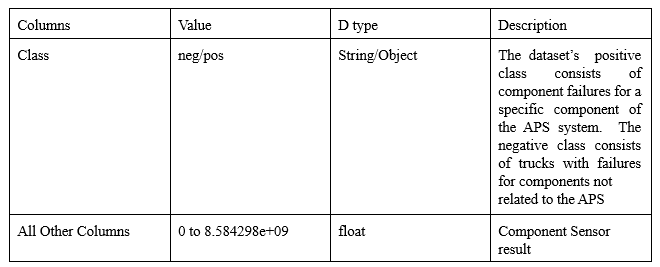

In [148]:
Image(filename="data_dictionary.png")

<b>Selection of Functions Used

In [6]:
def prelim(df):
    print(f"Dataframe Shape: {df.shape} \n")
    print(f"Dataframe statistical information: \n{df.describe()} \n")
    print(f"Object datatype statistical information: \n{df.describe(include=object)} \n")
    print(f"Dataframe info function: \n{df.info()} \n")
    print(df.isnull().sum())

In [7]:
# function that views the missing values of the first x row's
def missing_values_vis(df, end_row, title="Missing Values Matrix"):
    subset_1 = df.iloc[:end_row, :85]
    subset_2 = df.iloc[:end_row, 85:]
    
    fig, axes = plt.subplots(2, 1, figsize=(20, 12))

    msno.matrix(subset_1, ax=axes[0], sparkline=False)
    axes[0].set_title('Subset 1: Missing Values in Features 1 - 84')

    axes[0].set_xticks(range(len(subset_1.columns)))
    axes[0].set_xticklabels(subset_1.columns, rotation=90)

    msno.matrix(subset_2, ax=axes[1], sparkline=False)
    axes[1].set_title('Subset 2: Missing Values in Features 85 - 171')

    axes[1].set_xticks(range(len(subset_2.columns)))
    axes[1].set_xticklabels(subset_2.columns, rotation=90)
    
    plt.suptitle(title, fontsize=20)

    plt.show()

In [8]:
# basic countplot
def countplot(df, var, x_size=4, y_size=4, title="Countplot", x_label="Values", y_label="Count",
             rotate_xticks=0):
    plt.figure(figsize=(x_size, y_size))
    bw_palette = sns.color_palette("Paired")
    sns.set_palette(bw_palette)
    sns.countplot(data=df, x=var)#, hue=var) hue thins the bars..
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=rotate_xticks)
    plt.title(title)
    plt.show()

In [9]:
# original df vs log transformed df
def histo_v_loghisto(var):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Creating a 1x2 grid for plots

    # original histogram
    axes[0].hist(df[var], bins=10)
    axes[0].set_title(f"Original dataframe distribution of the {var} feature")
    axes[0].set_xlabel("Values")
    axes[0].set_ylabel("Frequency")

    # log transformed histogram
    axes[1].hist(df_log_transformed[var], bins=10)
    axes[1].set_title(f"Log transformed dataframe distribution of the {var} feature")
    axes[1].set_xlabel("Values")
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [10]:
def make_sparse_df(df):

    # make df, adding total entries now so it's at the start
    sparse_df = pd.DataFrame(columns=["total entries"])
    
    # total num of zeros
    total_zeros = df.eq(0).sum()
    sparse_df["total_zeros"] = total_zeros

    # total % of zeros
    zero_percentages = (total_zeros / len(df)) * 100
    sparse_df["zero_percentages"] = zero_percentages

    # total num of null
    total_null = df.isnull().sum()
    sparse_df["total_null"] = total_null

    # total % of null
    null_percentages = (total_null / len(df)) * 100
    sparse_df["null_percentages"] = null_percentages
    
    # 60000 for each row
    sparse_df["total entries"] = len(df)
    
    # total sparse %
    sparse_df["total_sparce_percent"] = sparse_df["zero_percentages"] + sparse_df["null_percentages"]
    
    return sparse_df

In [11]:
# plotting row
# missing values are filled as 0 
def row_plot(df, row_num=0, y_start=0, y_end=80, title=None):

    row = df.iloc[row_num, y_start:y_end]

    # Fill missing values with 0
    row_filled = row.fillna(0)
    
    if title is not None:
        title = f" of {title}"
    else:
        title = ""
        
    
    plt.figure(figsize=(16, 4))

    # Plot the data points
    plt.plot(row_filled, label=f"Values (0 - {row_filled.max():.2e})", color="black")

    # missing values
    missing_indices = row.index[row.isnull()]
    missing_values = row_filled[missing_indices]
    plt.plot(missing_indices, missing_values, linestyle="",  marker="o", markersize=4, color="red", label="Missing Data (filled as zero)")

    plt.xlabel(f"Features {y_start+1} - {y_end+1}, from 171 total features")
    plt.ylabel(f"Values (0 - {row_filled.max():.2e})")
    plt.title(f"Values for Row {row_num}{title}")
    
    plt.xticks(rotation=75)
    
    # legend
    plt.legend()

    plt.show()

In [12]:
def row_plot2(df, row_num=0, y_start=0, y_end=80, title=None):
    row = df.iloc[row_num, y_start:y_end]

    # Fill missing values with 0
    row_filled = row.fillna(0)
    
    if title is not None:
        title = f" of {title}"
    else:
        title = ""
        
    plt.figure(figsize=(16, 4))

    # Scatter plot for the data points
    plt.scatter(row_filled.index, row_filled, label=f"Values (0 - {row_filled.max():.2e})", color="black")

    # Scatter plot for missing values
    missing_indices = row.index[row.isnull()]
    missing_values = row_filled[missing_indices]
    plt.scatter(missing_indices, missing_values, color="red", label="Missing Data (filled as zero)", marker="o", s=50)

    plt.xlabel(f"Features {y_start+1} - {y_end+1}, from 171 total features")
    plt.ylabel(f"Values (0 - {row_filled.max():.2e})")
    plt.title(f"Values for Row {row_num}{title}")
    
    plt.xticks(rotation=75)
    
    # legend
    plt.legend()

    plt.show()

In [13]:
# maybe use a function to shade missing values
def row_plot_missing(row):
    row_filled = row.fillna(0)

In [14]:
def undersample(df):
    data = df
    X = data.drop(columns=['class'])  
    y = data['class']


    class_counts = y.value_counts()


    desired_samples = 1000
    sampling_strategy = {
        class_label: desired_samples
        for class_label, count in class_counts.items()
    }


    undersampler = RandomUnderSampler(sampling_strategy={class_label: 1000 
                                                         for class_label, 
                                                         count in class_counts.items()
                                                        }
                                      , random_state=88)


    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    undersampled_data = pd.concat([X_resampled, y_resampled], axis=1)
    return undersampled_data

In [15]:
def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="RdBu", fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

## 2. Results

### 2.1. Exploratory Data Analysis

<b>First Preliminary Exploration

Using pandas functions for summary statistics some things are noticed. There are 60000 entries and 171 features. 170 of the 171 columns are categories as they have "na" values, although they seem to be numerical.

In [16]:
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,305200,283680,na,na,na,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,na,10476,1226,267998,521832,428776,4015854,895240,26330,118,0,532,734,4122704,51288,0,532572,0,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,1996924,99560,0,7336,7808,13776,13086,1010074,1873902,14726,6,0,0,1378576,447166,199512,154298,137280,138668,165908,229652,87082,4708,3646660,86,454,364,350,1393352,49028,688314,392208,341420,359780,366560,na,na,na,na,na,6700,33057.51,3646660,3646660,3582034,17733.0,260120,115626,6900,2942850,1209600,0,na,na,na,2291079.36,0,643536.96,0,0,0,0,38,98644,1179502,1286736,336388,36294,5192,56,na,0,3646660,na,6160,796,164860,350066,272956,1837600,301242,9148,22,0,na,na,na,na,na,na,na,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,239798,1450312,0,1620,1156,1228,34250,1811606,710672,34,0,0,0,790690,672026,332340,254892,189596,135758,103552,81666,46,0,2673338,128,202,576,4,1234132,28804,160176,139730,137160,130640,na,na,na,na,na,na,28000,41040.08,2673338,2673338,2678534,15439.0,7466,22436,248240,2560566,1209600,63328,0,124,0,2322692.16,0,236099.52,0,0,0,0,0,33276,1215280,1102798,196502,10260,2422,28,0,6,2673338,na,3584,500,56362,149726,100326,1744838,488302,16682,246,0,230,292,2180528,29188,22,20346,0,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,2038,5596,0,64,6,6,914,76,2478,2398,1692,0,0,6176,340,304,102,74,406,216,16,0,0,21614,2,12,0,0,2668,184,7632,3090,na,na,na,na,na,na,na,na,10580,12.69,21614,21614,21772,32,50,1994,21400,7710,120960

In [17]:
df.dtypes

class     object
aa_000     int64
ab_000    object
ac_000    object
ad_000    object
           ...  
ee_007    object
ee_008    object
ee_009    object
ef_000    object
eg_000    object
Length: 171, dtype: object

In [18]:
prelim(df)

Dataframe Shape: (60000, 171) 

Dataframe statistical information: 
             aa_000
count  6.000000e+04
mean   5.933650e+04
std    1.454301e+05
min    0.000000e+00
25%    8.340000e+02
50%    3.077600e+04
75%    4.866800e+04
max    2.746564e+06 

Object datatype statistical information: 
        class ab_000 ac_000 ad_000 ae_000 af_000 ag_000 ag_001 ag_002 ag_003  \
count   60000  60000  60000  60000  60000  60000  60000  60000  60000  60000   
unique      2     30   2062   1887    334    419    155    618   2423   7880   
top       neg     na      0     na      0      0      0      0      0      0   
freq    59000  46329   8752  14861  55543  55476  59133  58587  56181  46894   

       ag_004 ag_005 ag_006 ag_007 ag_008 ag_009 ah_000 ai_000 aj_000 ak_000  \
count   60000  60000  60000  60000  60000  60000  60000  60000  60000  60000   
unique  23072  40798  40616  32126  18933   5356  43572   4056    895    160   
top         0      0      0      0      0      0     na      0     

<b>Setting null values

A quick way to remedy this is to reload the dataset setting "na" as a null value. By default, Pandas does not include "na" as a null value*, and this can be added with the na_values function.

**pandas documentation https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html*

In [19]:
df = pd.read_csv("aps_failure_set.csv", na_values="na")

In [20]:
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,755876.0,0.0,5374.0,2108.0,4114.0,12348.0,615248.0,5526276.0,2378.0,4.0,0.0,0.0,2328746.0,1022304.0,415432.0,287230.0,310246.0,681504.0,1118814.0,3574.0,0.0,0.0,6700214.0,0.0,10.0,108.0,50.0,2551696.0,97518.0,947550.0,799478.0,330760.0,353400.0,299160.0,305200.0,283680.0,NaN,NaN,NaN,178540.0,76698.08,6700214.0,6700214.0,6599892.0,43566.0,68656.0,54064.0,638360.0,6167850.0,1209600.0,246244.0,2.0,96.0,0.0,5245752.00,0.0,916567.68,6.0,1924.0,0.0,0.0,0.0,118196.0,1309472.0,3247182.0,1381362.0,98822.0,11208.0,1608.0,220.0,240.0,6700214.0,NaN,10476.0,1226.0,267998.0,521832.0,428776.0,4015854.0,895240.0,26330.0,118.0,0.0,532.0,734.0,4122704.0,51288.0,0.0,532572.0,0.0,18.0,5330690.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,99560.0,0.0,7336.0,7808.0,13776.0,13086.0,1010074.0,1873902.0,14726.0,6.0,0.0,0.0,1378576.0,447166.0,199512.0,154298.0,137280.0,138668.0,165908.0,229652.0,87082.0,4708.0,3646660.0,86.0,454.0,364.0,350.0,1393352.0,49028.0,688314.0,392208.0,341420.0,359780.0,366560.0,NaN,NaN,NaN,NaN,NaN,6700.0,33057.51,3646660.0,3646660.0,3582034.0,17733.0,260120.0,115626.0,6900.0,2942850.0,1209600.0,0.0,NaN,NaN,NaN,2291079.36,0.0,643536.96,0.0,0.0,0.0,0.0,38.0,98644.0,1179502.0,1286736.0,336388.0,36294.0,5192.0,56.0,NaN,0.0,3646660.0,NaN,6160.0,796.0,164860.0,350066.0,272956.0,1837600.0,301242.0,9148.0,22.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,239798.0,1450312.0,0.0,1620.0,1156.0,1228.0,34250.0,1811606.0,710672.0,34.0,0.0,0.0,0.0,790690.0,672026.0,332340.0,254892.0,189596.0,135758.0,103552.0,81666.0,46.0,0.0,2673338.0,128.0,202.0,576.0,4.0,1234132.0,28804.0,160176.0,139730.0,137160.0,13064

In [21]:
df.dtypes

class      object
aa_000      int64
ab_000    float64
ac_000    float64
ad_000    float64
           ...   
ee_007    float64
ee_008    float64
ee_009    float64
ef_000    float64
eg_000    float64
Length: 171, dtype: object

<b>Second Preliminary Exploration

Now when the same statistical function is performed only one feature remains categorical, and the other features have been automatically loaded as numerical.

In [22]:
prelim(df)

Dataframe Shape: (60000, 171) 

Dataframe statistical information: 
             aa_000        ab_000        ac_000        ad_000        ae_000  \
count  6.000000e+04  13671.000000  5.666500e+04  4.513900e+04  57500.000000   
mean   5.933650e+04      0.713189  3.560143e+08  1.906206e+05      6.819130   
std    1.454301e+05      3.478962  7.948749e+08  4.040441e+07    161.543373   
min    0.000000e+00      0.000000  0.000000e+00  0.000000e+00      0.000000   
25%    8.340000e+02      0.000000  1.600000e+01  2.400000e+01      0.000000   
50%    3.077600e+04      0.000000  1.520000e+02  1.260000e+02      0.000000   
75%    4.866800e+04      0.000000  9.640000e+02  4.300000e+02      0.000000   
max    2.746564e+06    204.000000  2.130707e+09  8.584298e+09  21050.000000   

             af_000        ag_000        ag_001        ag_002        ag_003  \
count  57500.000000  5.932900e+04  5.932900e+04  5.932900e+04  5.932900e+04   
mean      11.006817  2.216364e+02  9.757223e+02  8.606015e+03 

<b>Categorical Features: Class variable

The class variable is the only categorical variable left in the dataset. It is a binary category with two values; "neg" and "pos". It has no missing data and it is unbalanced.

At this stage the class variable is encoded; 1 for 'pos', 0 for 'neg'.

In [23]:
df["class"].isnull().sum()

0

In [24]:
df["class"].value_counts()

class
neg    59000
pos     1000
Name: count, dtype: int64

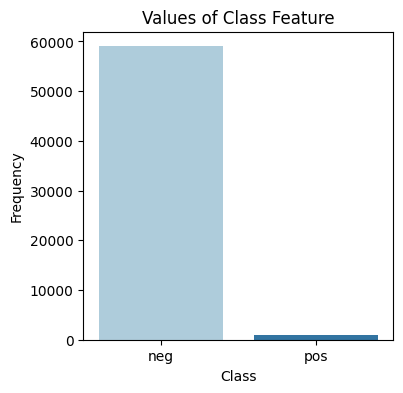

In [25]:
countplot(df, "class", title="Values of Class Feature",
         x_label="Class", y_label="Frequency")

In [26]:
# only one variable to be encoded
mapping = {'neg': 0, 'pos': 1}
df['class'] = df['class'].map(mapping)

<b> Numerical Features: Rest of Features

<b> Range

Range is one summary statistic used to summarise spread (Spiegelhalter, p. 49). 

Below the minimum and of each feature is shown. It shows that most features (2 have minimums of 172 and 1209600) have a minimum of 0, and that all numerical values are positive in the dataset.

The maximum values have values ranging from 2 to 8 billion. For most features the range is the maximum value, as 0 is their lowest. So instead of a plot of the maximum values, a plot of binned ranges is shown.

Overall the ranges are very large, and makes scaling of this data sensible.

In [27]:
min_values = np.min(df.iloc[:, 1:], axis=0)
max_values = np.max(df.iloc[:, 1:], axis=0)

In [28]:
min_df = pd.DataFrame(min_values, columns=["min_values"])
max_df = pd.DataFrame(max_values, columns=["max_values"])

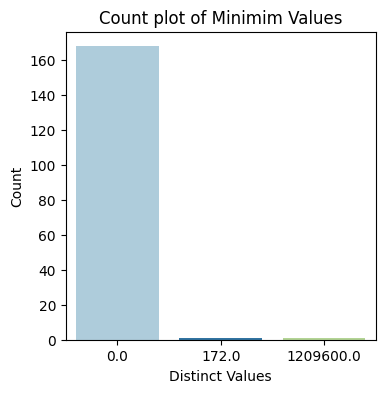

In [29]:
countplot(min_df, "min_values", title="Count plot of Minimim Values",
         x_label="Distinct Values")

In [30]:
range_df = max_values - min_values
range_df = pd.DataFrame(range_df, columns=["feature_range"])

In [31]:
# test log scale for this
# right is set to false so these will be the edges of the bins
bin_edges = [0, 1000, 10000, 100000, 1000000, 10000000, 100000000, 500000000, 1000000000, float('inf')]

# bin labels
bin_labels = ["0 - 1000", "1001 - 10,000", "10,001 - 100,000", "100,000 - 1 million", "1 million - 10 million", 
              "10 million - 100 million", "100 million - 500 million", "500 million - 1 billion", "1 billion - 8 billion"]  

range_df['bins'] = pd.cut(range_df["feature_range"], bins=bin_edges, labels=bin_labels, right=False)
   

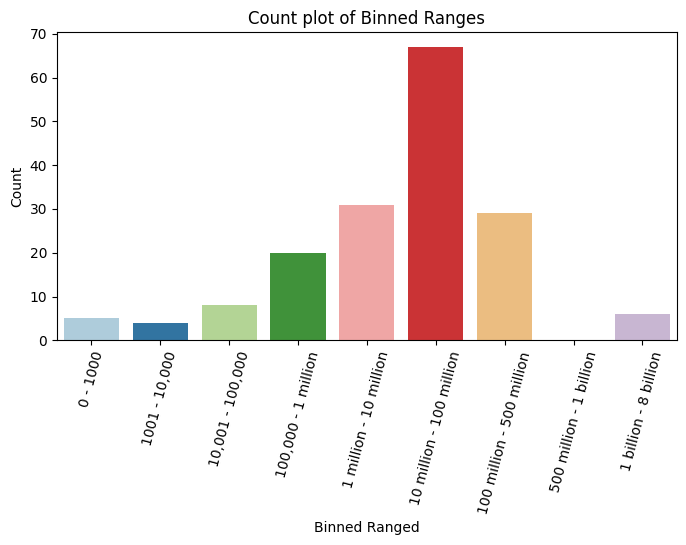

In [32]:
countplot(range_df, "bins", title="Count plot of Binned Ranges",
         x_label="Binned Ranged", x_size=8, rotate_xticks=75)

<b>Inner Quartile Range

The innerquartile range (IQR) is a another measure of spread of a variable. It is less susceptable to extreme values than the range (Spiegelhalter, p. 49). Using pandas head function above showed many columns with an IQR of 0.

Features with IQR of 0 vs. Features with Non-zero IQR can be plotted to give an idea of how prevelant an IQR of 0 is in the dataset, and below it can be seen that 36.8% of columns have an IQR of 0.

The data is fairly sparse and it's possible that the outliers are associated with certain failures, or vice-versa.

In [33]:
df1 = df.drop("class", axis=1)
iqr = df1.quantile(0.75) - df1.quantile(0.25)


features_with_iqr_zero = iqr[iqr == 0].index
df_iqr_zero = df[features_with_iqr_zero]

df_iqr_non_zero = df.drop(columns=features_with_iqr_zero)

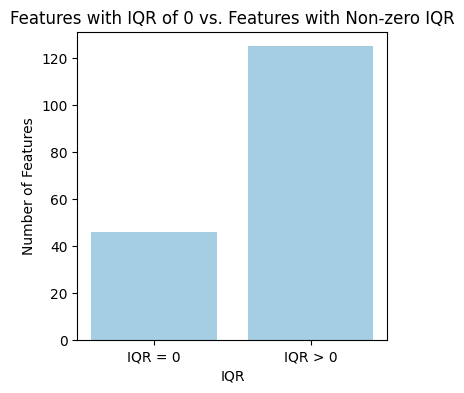

In [34]:
plt.figure(figsize=(4, 4))
plt.bar(['IQR = 0', 'IQR > 0'], [len(df_iqr_zero.columns), len(df_iqr_non_zero.columns)])

plt.xlabel('IQR')
plt.ylabel('Number of Features')
plt.title('Features with IQR of 0 vs. Features with Non-zero IQR')
plt.show()

In [35]:
len(df_iqr_zero.columns)

46

In [36]:
len(df_iqr_non_zero.columns)

125

In [37]:
print(f"Percentage of 0 IQR features: {len(df_iqr_zero.columns)/len(df_iqr_non_zero.columns)*100}")

Percentage of 0 IQR features: 36.8


<b> Data Skew

Around a third of the data has an IQR of 0. This indicates that some of the data is skewed or has large outliers, given that the binned ranges have values in the thousands or above (upto billions).

In the describe function's output above, the means and medians didn't seem very similar, therefor it's useful to look at the skew of the data which can also be plotted to be more understandable.

Interestingly, one feature ("cd_000") has a skew of 0, but when inspecting it isn't a normally distributed feature, instead it has the same value for each entry with a small number of missing values.

If we ignore this feature, the remaining features have a right skew, ranging from a slight skew to a large skew.

In [38]:
skew_values = df.drop("class", axis=1).skew()
print(skew_values.min())
print(skew_values.max())

0.0
243.53117726282542


In [39]:
zero_skew = skew_values[skew_values==0]
zero_skew

cd_000    0.0
dtype: float64

In [40]:
df["cd_000"].value_counts()

cd_000
1209600.0    59324
Name: count, dtype: int64

In [41]:
df["cd_000"].isnull().sum()

676

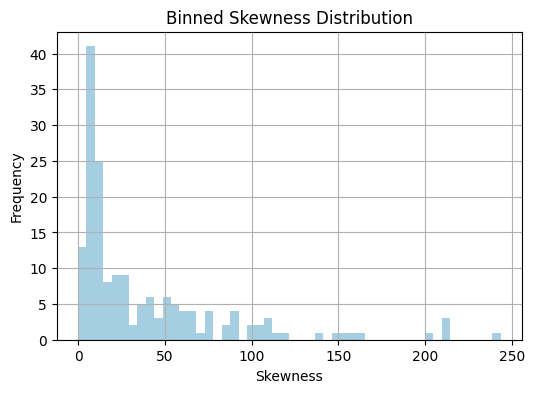

In [42]:
skew_values.hist(bins=50, figsize=(6, 4))
plt.title('Binned Skewness Distribution')
plt.xlabel("Skewness")
plt.ylabel("Frequency")
plt.show()

<b>Individual Features Histograms

Or course, individual features can be plotted with histograms and boxplots to display this also. But the two previous grouped plots lead a more understanding of overall data.

When we plot the cd_000 feature we see what we surmised with the pandas functions.

Plotting a log transformation vs. the original feature which reduces the impact of the extreme values (Spiegelhalter, p. 44). (negative numbers are zero'd here for visualisation purposes only, which may add a band of zeros to some of the log distribution visualisations.)

In [43]:
df_log = df.drop("class", axis=1)
df_log_transformed = df_log.apply(lambda x: np.log(x) if np.issubdtype(x.dtype, np.number) else x)
df_log_transformed = df_log_transformed.replace(-np.inf, 0)
df_log_transformed = pd.concat([df["class"], df_log_transformed], axis=1)

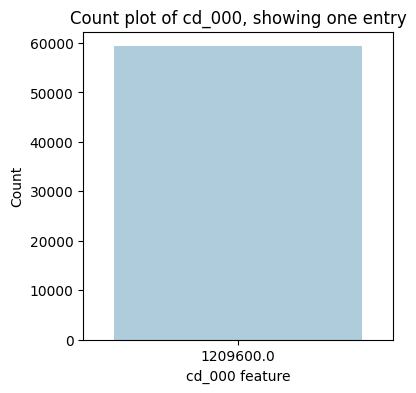

In [44]:
countplot(df, "cd_000", title="Count plot of cd_000, showing one entry", 
          x_label="cd_000 feature")

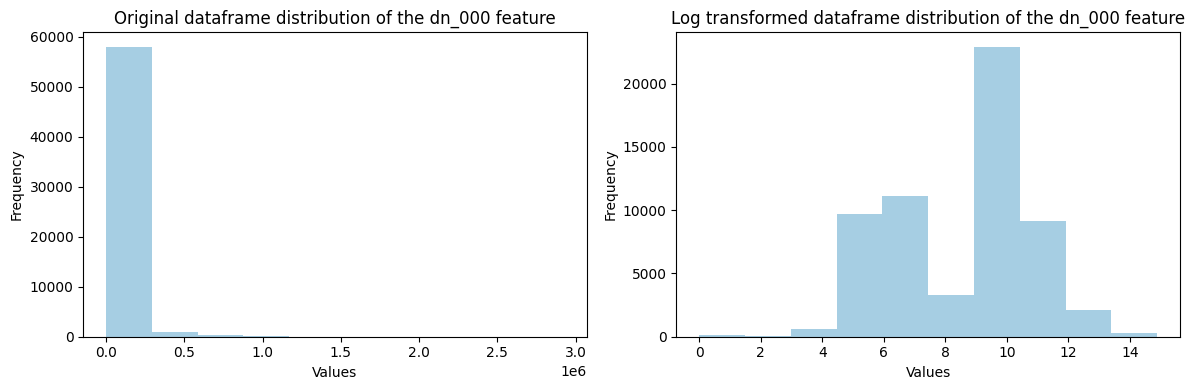

In [45]:
histo_v_loghisto("dn_000")

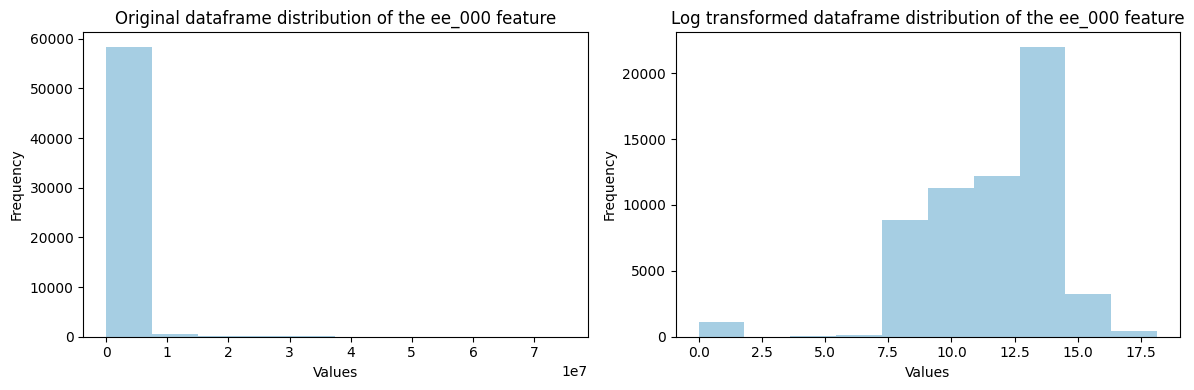

In [46]:
histo_v_loghisto("ee_000")

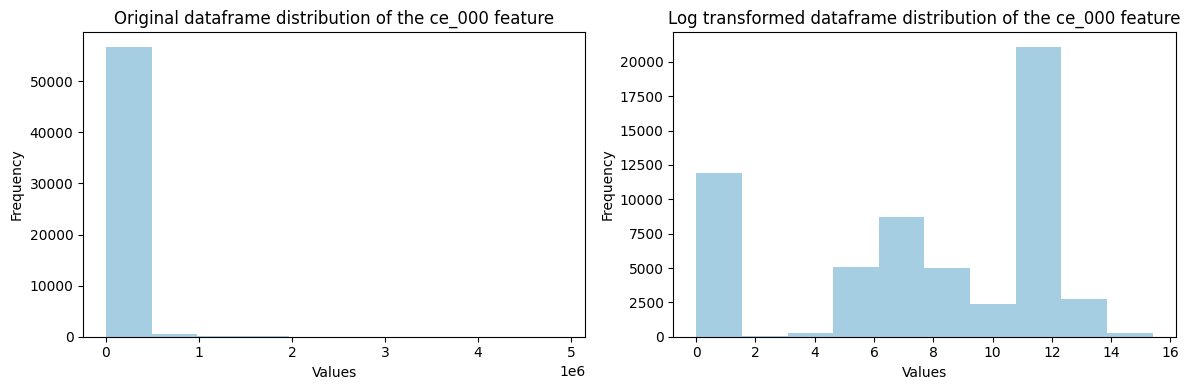

In [47]:
histo_v_loghisto("ce_000")

<b>Box plots

 Box plots, the log transformation isn't used as it changes the characteristics of the outliers. The first two plots have an IQR of 0.
 
 The same selection of features used in the histograms above is shown, which show outliers with a large magnitude. A few things had already indicated this; the skewness, ranges, IQR's, and scale of the data,

In [48]:
def simple_boxplot(df, var):
    plt.figure(figsize=(4, 4))
    sns.boxplot(data=df[var])
    plt.title(f'Boxplot of {var}')
    plt.ylabel('Values')
    plt.show()

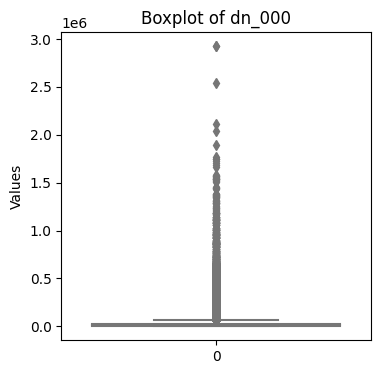

In [49]:
simple_boxplot(df, "dn_000")

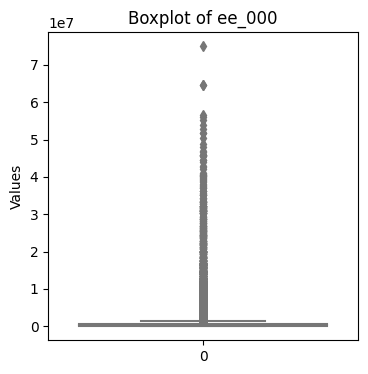

In [50]:
simple_boxplot(df, "ee_000")

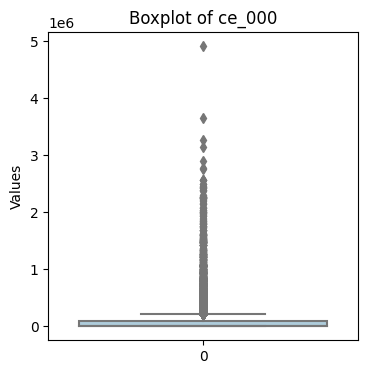

In [51]:
simple_boxplot(df, "ce_000")

<b>Correlations

A correlation heatmap shows that the data is mostly positively correlated or neutral. There is a grouping of features that are negatively correlated or neutral with most other features.

When correlations are plotted for the different class values the same pattern appears. However, the positive class does seem to have more neutral correlations and the band of negatively correlated data is gone.

This indicates at least some differences exist that could be used to predict class, which will be explored later.

In [52]:
correlation_matrix = df.corr()
correlation_matrix.shape

(171, 171)

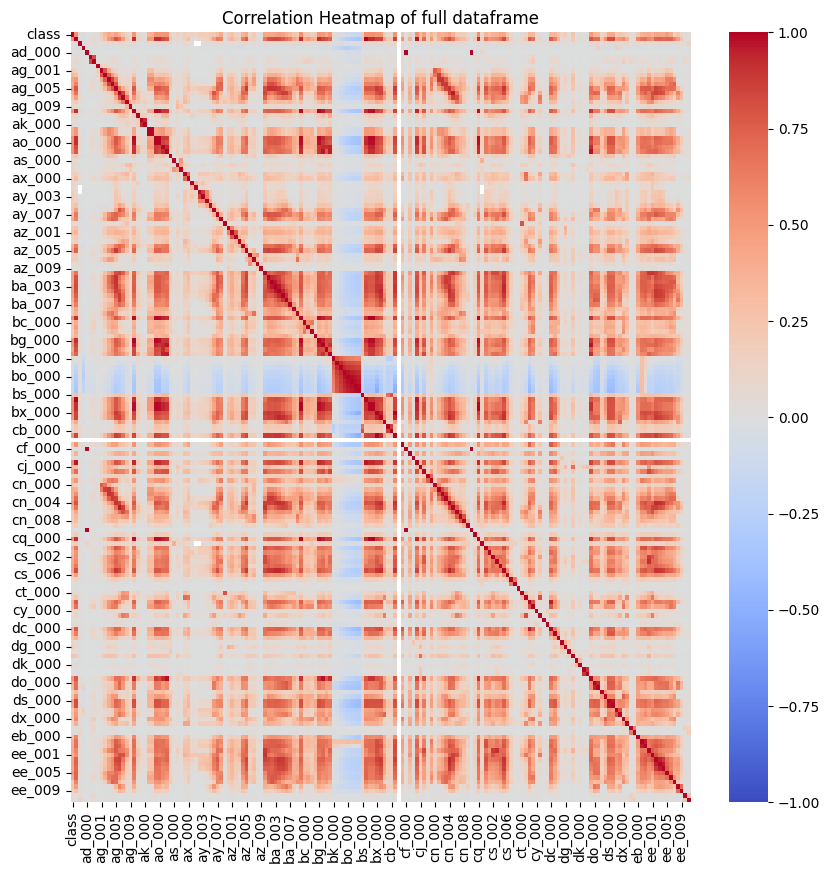

In [53]:
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap of full dataframe')
plt.show()

In [54]:
df_neg = df[df["class"]==0]
df_pos = df[df["class"]==1]

In [55]:
correlation_matrix_neg = df_neg.corr()
correlation_matrix_pos = df_pos.corr()

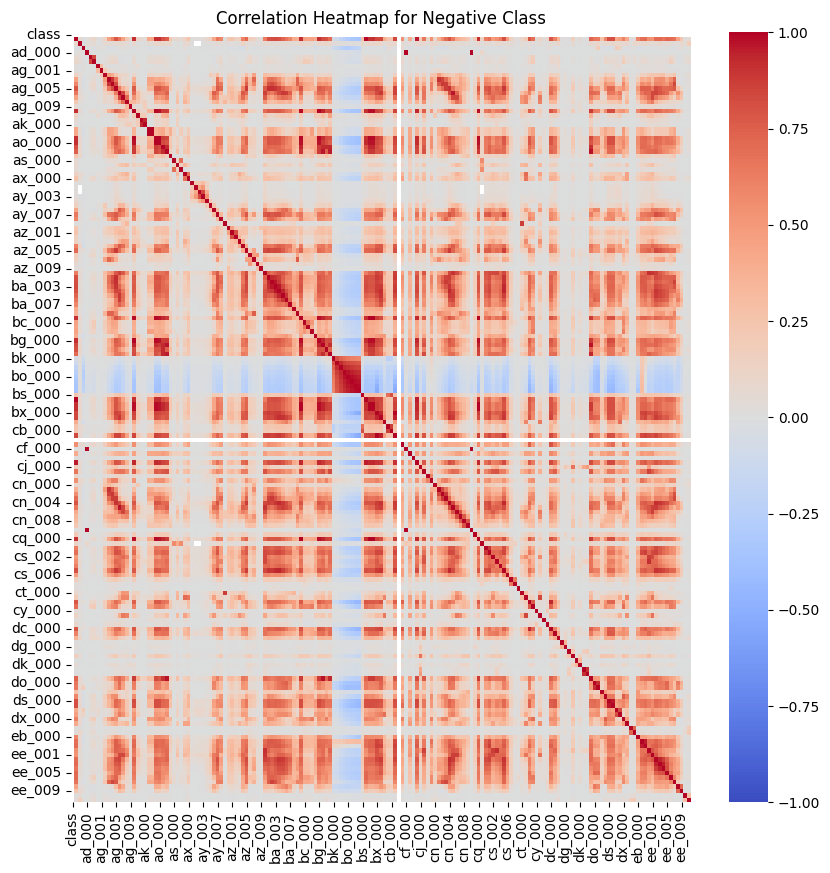

In [56]:
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix_neg, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Negative Class')
plt.show()

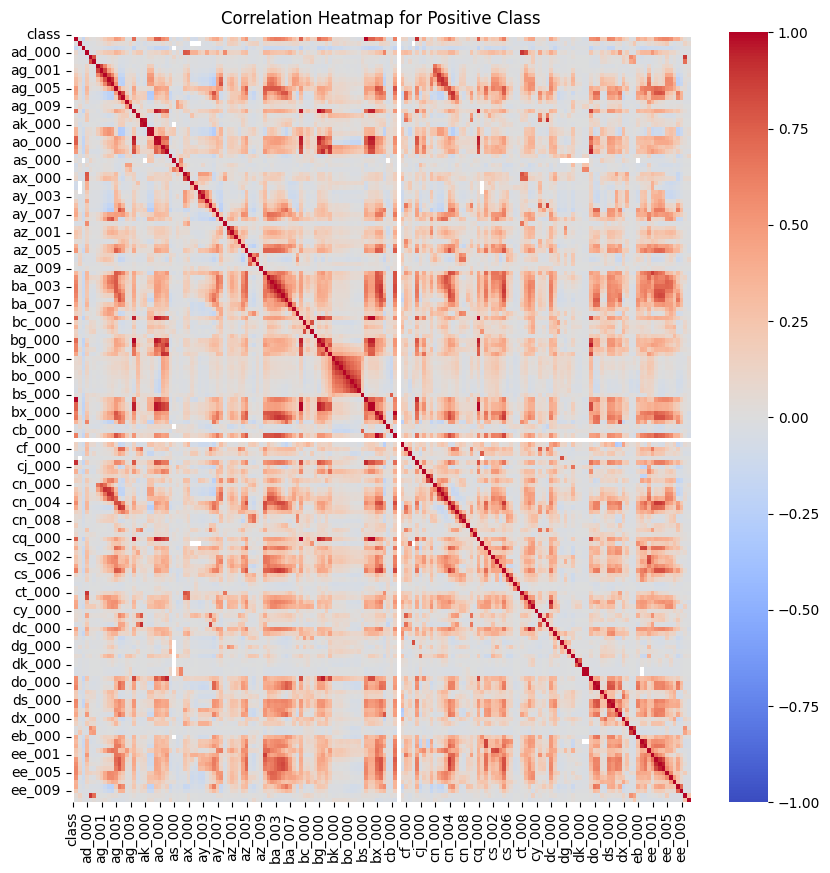

In [57]:
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix_pos, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Positive Class')
plt.show()

<b>Percentage of sparse data

As noted, the data is considerable sparse. Below it shows that only 2 features have no zero values, and only one feature (apart from class) have no null values.

Also plotted below are the percentage of null values, and percentage of zero values. Reinforcing the idea that the data is overall quite sparse.

In [58]:
sparse_df = make_sparse_df(df)
# ignoring class as it's mostly zeros now
sparse_df.iloc[1:,:].head()

,total entries,total_zeros,zero_percentages,total_null,null_percentages,total_sparce_percent
aa_000,60000,393,0.655000,0,0.000000,0.655000
ab_000,60000,10977,18.295000,46329,77.215000,95.510000
ac_000,60000,8752,14.586667,3335,5.558333,20.145000
ad_000,60000,2009,3.348333,14861,24.768333,28.116667
ae_000,60000,55543,92.571667,2500,4.166667,96.738333


In [59]:
zeros = sparse_df[sparse_df["total_zeros"]==0]
zeros

,total entries,total_zeros,zero_percentages,total_null,null_percentages,total_sparce_percent
bx_000,60000,0,0.0,3257,5.428333,5.428333
cd_000,60000,0,0.0,676,1.126667,1.126667


In [60]:
null = sparse_df[sparse_df["total_null"]==0]
null

,total entries,total_zeros,zero_percentages,total_null,null_percentages,total_sparce_percent
class,60000,59000,98.333333,0,0.0,98.333333
aa_000,60000,393,0.655000,0,0.0,0.655000


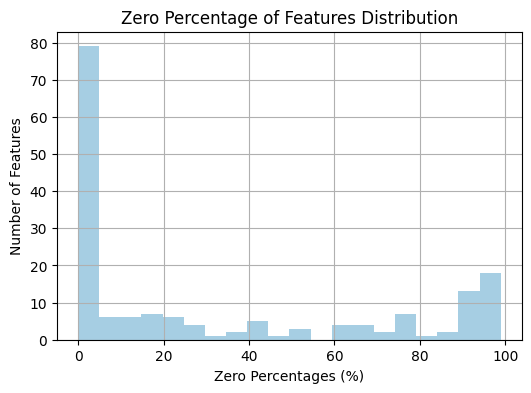

In [61]:
sparse_df["zero_percentages"].hist(bins=20, figsize=(6, 4))
plt.title('Zero Percentage of Features Distribution')
plt.xlabel("Zero Percentages (%)")
plt.ylabel("Number of Features")
plt.show()

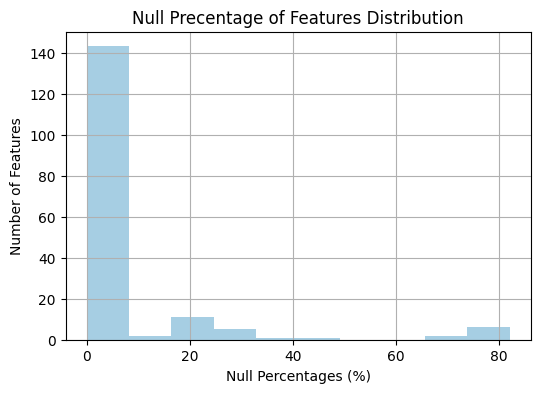

In [62]:
sparse_df["null_percentages"].hist(bins=10, figsize=(6, 4))
plt.title('Null Precentage of Features Distribution')
plt.xlabel("Null Percentages (%)")
plt.ylabel("Number of Features")
plt.show()

<b>Missing Values

Below a matrix of missing values is shown using the Missingno library, with white horizontal bands showing rows with groupings of missing data and vertical bars indicating features with missing data (slighter vertical bars indicate a separation of features).

Missingno matrix can be hard to interpid with a lot of data, and by limiting the data viewed patterns emerge.This indicates that the data may be non-random missing data (Harrison, 2019), but more exploration on that would be needed. Given that this dataset is of APS failure data, the bands or patterns could be related to specific failure types.

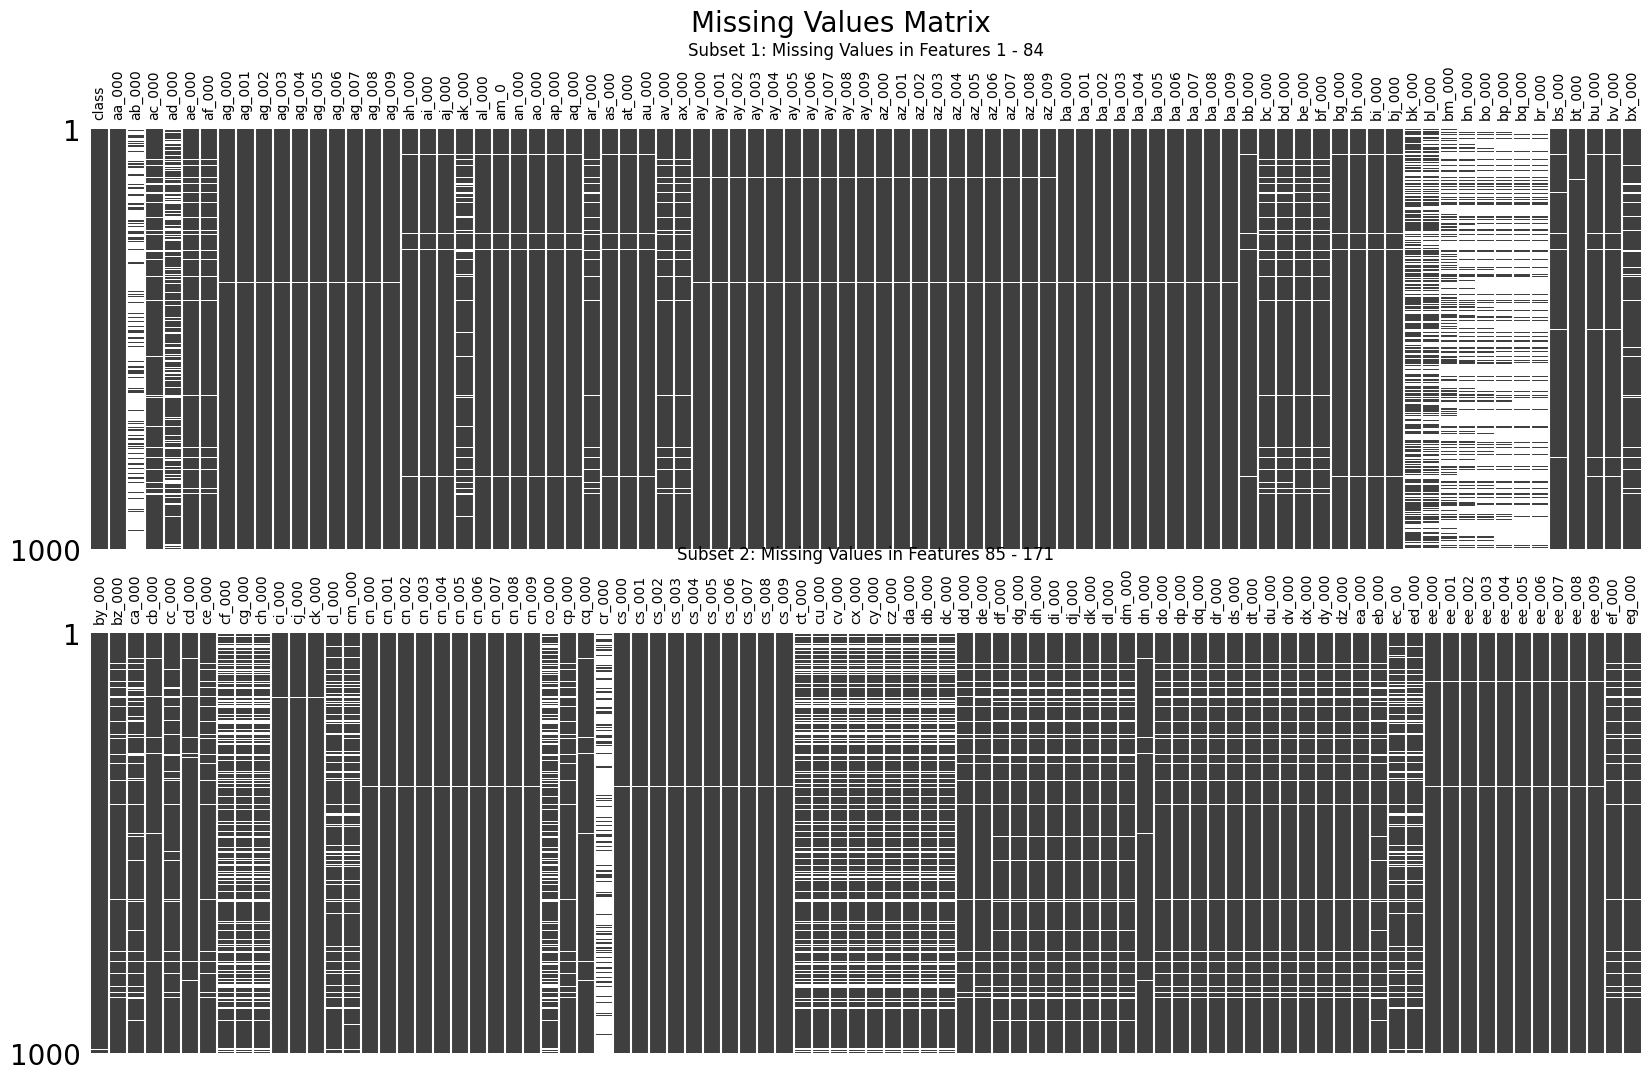

In [63]:
missing_values_vis(df, 1000)

<b>Missing values per "class" variable

Different patterns of missing values can be seen when the missing value matrix are split into the two different values of the "class" variable.

It might hint that they are related to the different states of "class".

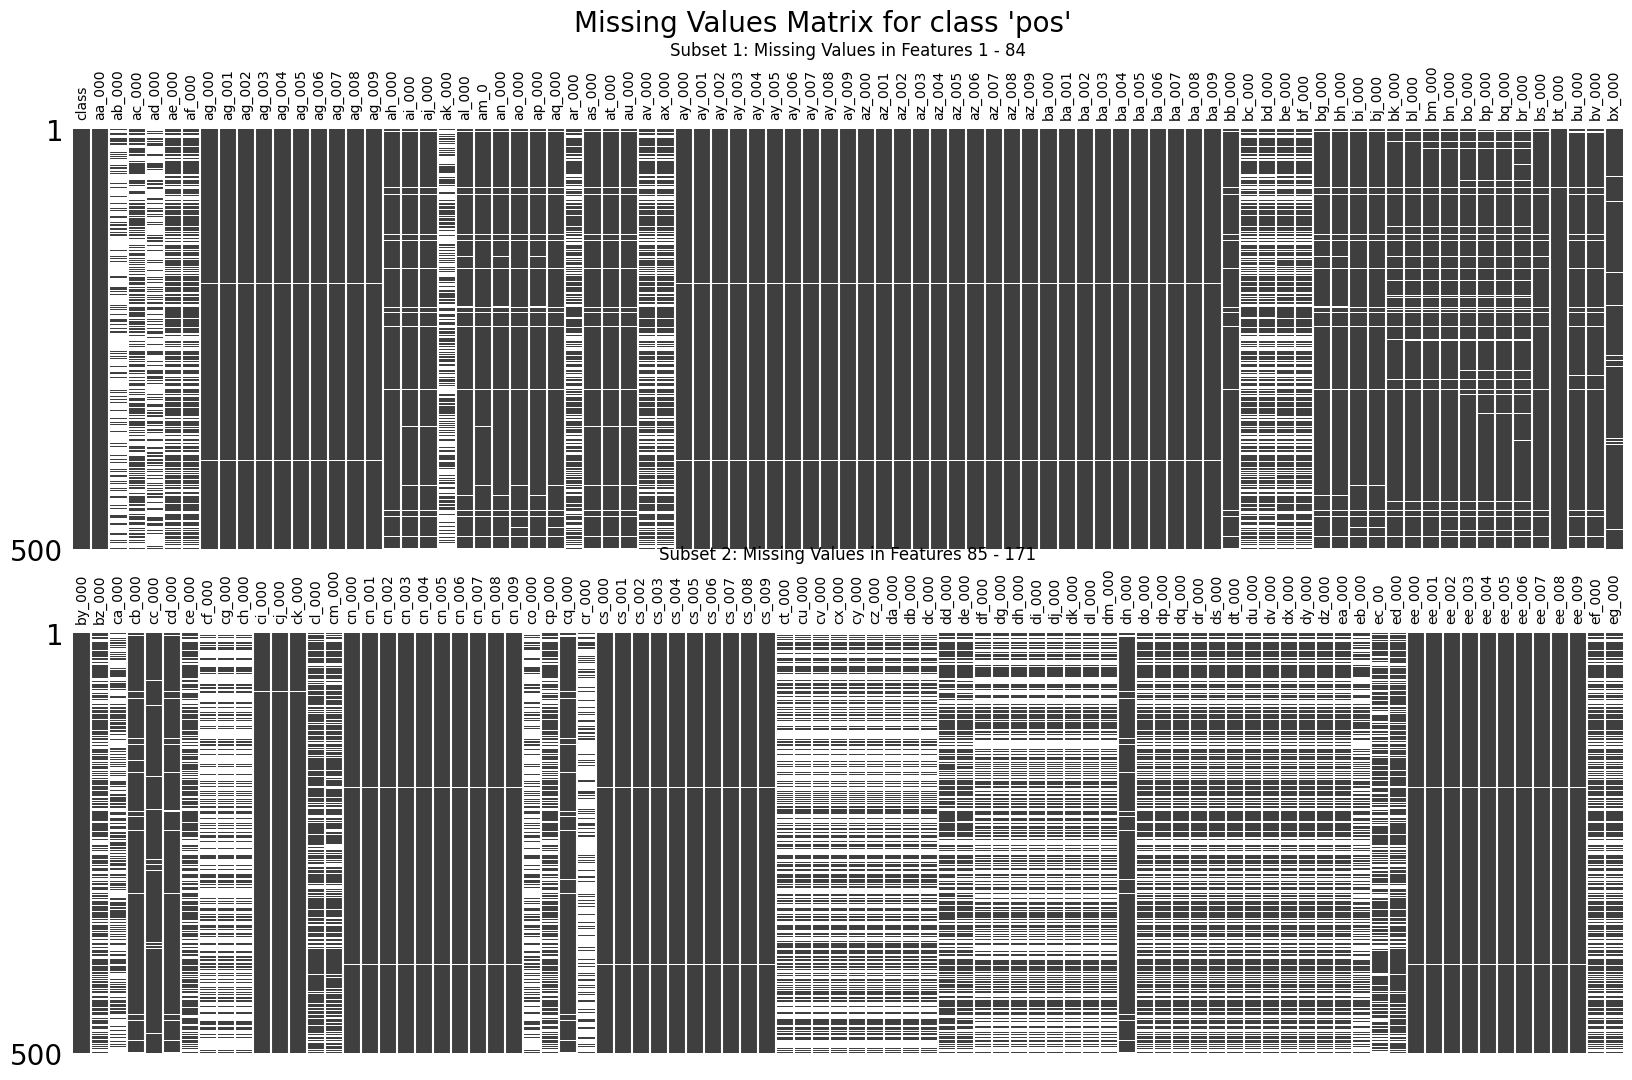

In [64]:
df1 = df[df["class"]==1]
missing_values_vis(df1, 500, "Missing Values Matrix for class 'pos'")

In [65]:
df

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,755876.0,0.0,5374.0,2108.0,4114.0,12348.0,615248.0,5526276.0,2378.0,4.0,0.0,0.0,2328746.0,1022304.0,415432.0,287230.0,310246.0,681504.0,1118814.0,3574.0,0.0,0.0,6700214.0,0.0,10.0,108.0,50.0,2551696.0,97518.0,947550.0,799478.0,330760.0,353400.0,299160.0,305200.0,283680.0,NaN,NaN,NaN,178540.0,76698.08,6700214.0,6700214.0,6599892.0,43566.0,68656.0,54064.0,638360.0,6167850.0,1209600.0,246244.0,2.0,96.0,0.0,5245752.00,0.00,916567.68,6.0,1924.0,0.0,0.0,0.0,118196.0,1309472.0,3247182.0,1381362.0,98822.0,11208.0,1608.0,220.0,240.0,6700214.0,NaN,10476.0,1226.0,267998.0,521832.0,428776.0,4015854.0,895240.0,26330.0,118.0,0.0,532.0,734.0,4122704.0,51288.0,0.0,532572.0,0.0,18.0,5330690.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,99560.0,0.0,7336.0,7808.0,13776.0,13086.0,1010074.0,1873902.0,14726.0,6.0,0.0,0.0,1378576.0,447166.0,199512.0,154298.0,137280.0,138668.0,165908.0,229652.0,87082.0,4708.0,3646660.0,86.0,454.0,364.0,350.0,1393352.0,49028.0,688314.0,392208.0,341420.0,359780.0,366560.0,NaN,NaN,NaN,NaN,NaN,6700.0,33057.51,3646660.0,3646660.0,3582034.0,17733.0,260120.0,115626.0,6900.0,2942850.0,1209600.0,0.0,NaN,NaN,NaN,2291079.36,0.00,643536.96,0.0,0.0,0.0,0.0,38.0,98644.0,1179502.0,1286736.0,336388.0,36294.0,5192.0,56.0,NaN,0.0,3646660.0,NaN,6160.0,796.0,164860.0,350066.0,272956.0,1837600.0,301242.0,9148.0,22.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,239798.0,1450312.0,0.0,1620.0,1156.0,1228.0,34250.0,1811606.0,710672.0,34.0,0.0,0.0,0.0,790690.0,672026.0,332340.0,254892.0,189596.0,135758.0,103552.0,81666.0,46.0,0.0,2673338.0,128.0,202.0,576.0,4.0,1234132.0,28804.0,160176.0,139730.0,137160.0,130640.0,

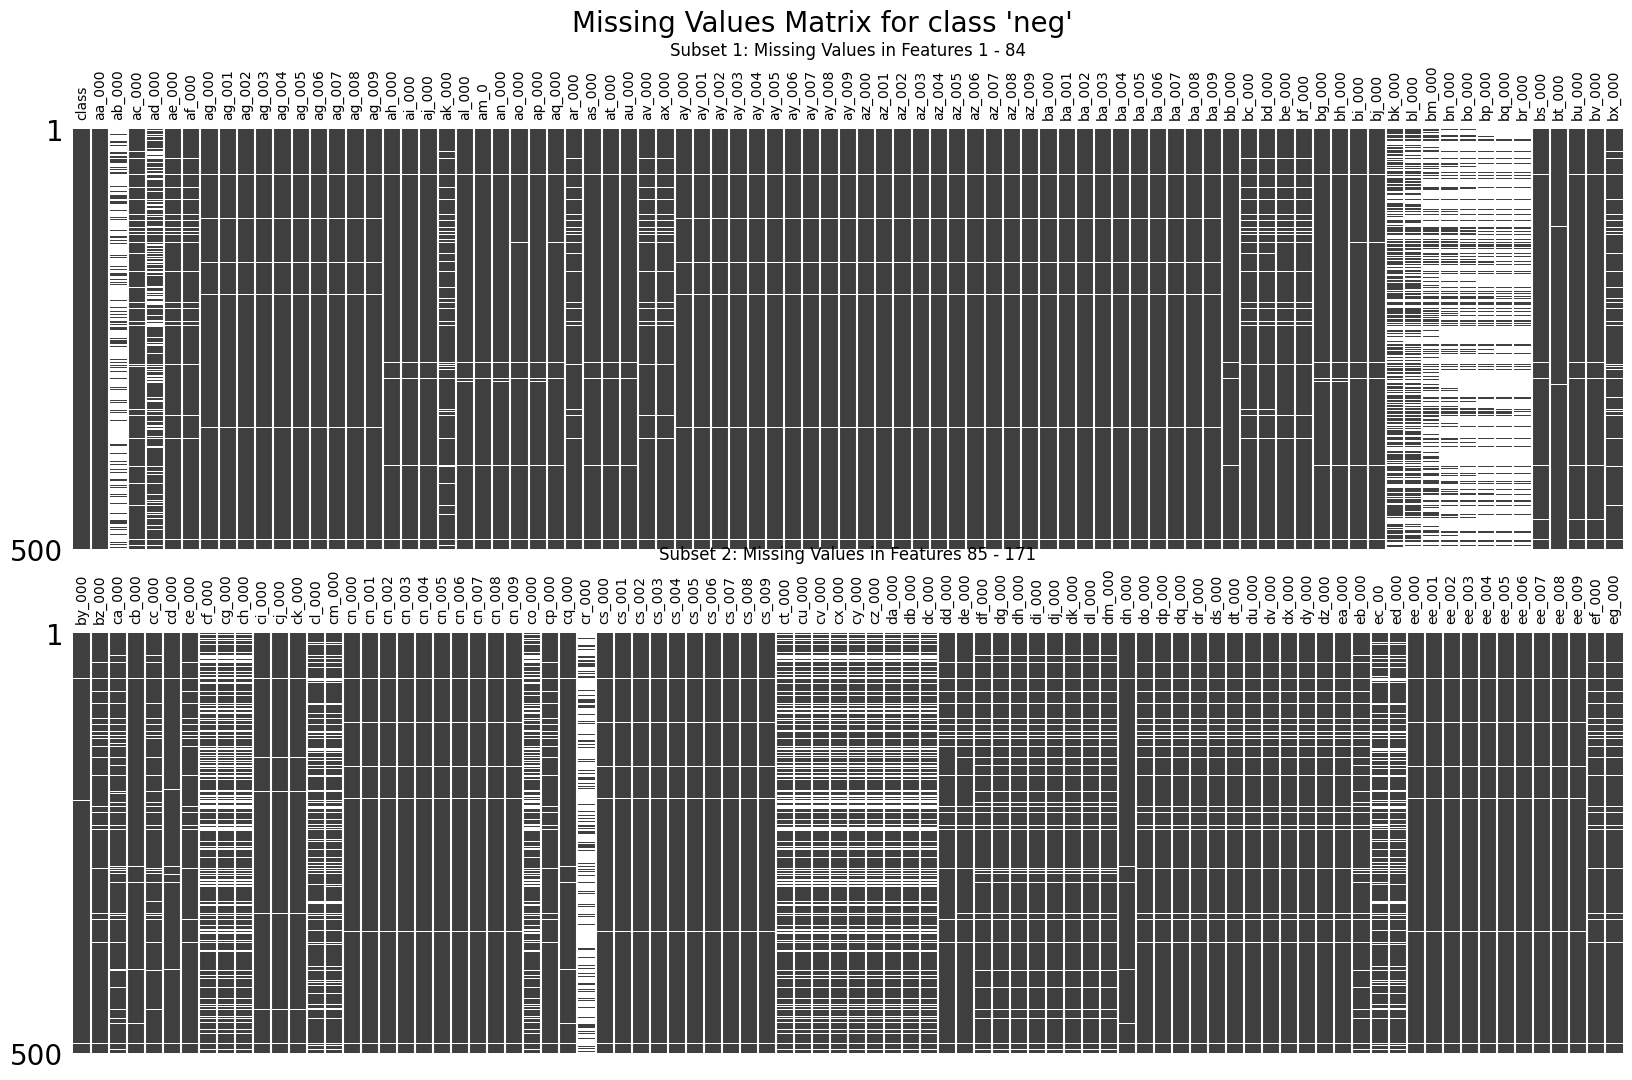

In [66]:
df1 = df[df["class"]==0]
missing_values_vis(df1, 500, "Missing Values Matrix for class 'neg'")

<b> Duplicates

Although their seems like considerable pattern to the null data, there are no duplicated rows in the dataset.

In [67]:
df_no_duplicates = df.drop_duplicates()

print(f"Original dataframe shape: {df.shape}")
print(f"Dropped dataframe shape: {df_no_duplicates.shape}")

Original dataframe shape: (60000, 171)
Dropped dataframe shape: (60000, 171)


<b>Features with the highest missing data

From the missing plots above, it's clear that there is some relationship between data being missing and and the features, with bands of missing data stretching across multiple features that seem to be grouped by the same 'prefix' (cs_000, cs_001, cs_002 etc).

It looks like some bands of missing data stretch across all features, although the visualisation is split and 500 features are shown, so to be sure it's checked below, and no rows contain all missing data.



In [68]:
rows_with_all_missing = df[df.isna().all(axis=1)]

rows_with_all_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(2)
memory usage: 0.0 bytes


In [69]:
missing_counts = df.isnull().sum()
sorted_columns = missing_counts.sort_values(ascending=False)
print(sorted_columns)

br_000    49264
bq_000    48722
bp_000    47740
bo_000    46333
ab_000    46329
          ...  
cj_000      338
ci_000      338
bt_000      167
aa_000        0
class         0
Length: 171, dtype: int64


In [70]:
missing_counts = missing_counts/60000 * 100

In [71]:
missing_counts

class      0.000000
aa_000     0.000000
ab_000    77.215000
ac_000     5.558333
ad_000    24.768333
            ...    
ee_007     1.118333
ee_008     1.118333
ee_009     1.118333
ef_000     4.540000
eg_000     4.538333
Length: 171, dtype: float64

In [72]:
missing_counts = pd.DataFrame(missing_counts, columns=["percent_missing"])

In [73]:
missing_counts = missing_counts.sort_values(ascending=False, by="percent_missing")
missing_counts

,percent_missing
br_000,82.106667
bq_000,81.203333
bp_000,79.566667
bo_000,77.221667
ab_000,77.215000
...,...
cj_000,0.563333
ci_000,0.563333
bt_000,0.278333
aa_000,0.000000


<Figure size 1400x800 with 0 Axes>

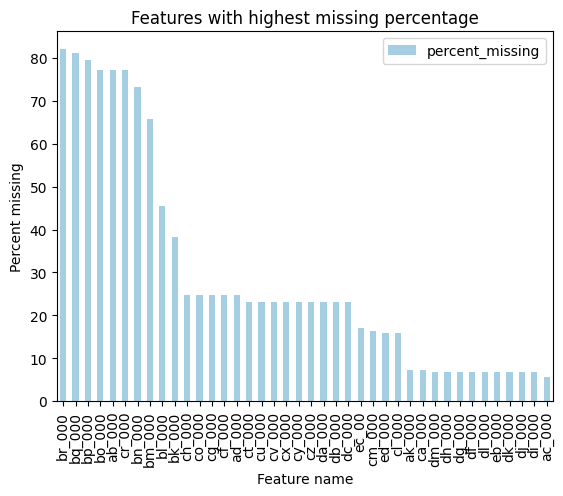

In [74]:
# dont show tail end which is represented in other
plt.figure(figsize=(14, 8))

missing_counts.iloc[:40].plot(
    kind='bar',        
    title='Features with highest missing percentage', 
    xlabel='Feature name', 
    ylabel='Percent missing'      
)


plt.show()

<b>Missing data percentage

In [75]:
missing_data = missing_counts['percent_missing']

bin_edges = [-1, 0.001, 20, 40, 60, 80, 100]  
binned_data_labels = ['0%', '0.001-20%', '20-40%', '40-60%', '60-80%', '80-100%']

binned_data = pd.DataFrame()
# Bin the data and convert to string
binned_data['bins'] = pd.cut(missing_counts["percent_missing"], bins=bin_edges, labels=binned_data_labels)#.astype(str)


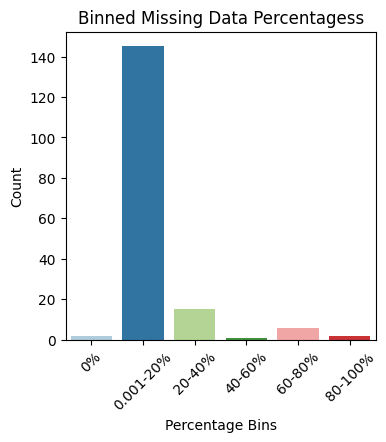

In [76]:
countplot(binned_data, "bins", title="Binned Missing Data Percentagess",
         x_label="Percentage Bins", rotate_xticks=45)

In [77]:
df1 =df.drop("class", axis=1)

In [78]:
type(sorted_columns)

pandas.core.series.Series

<b> Chi-squared Test

A Chi-squared test is useful in analysing the proportions of categories to determine if there is a significant difference between the proportions (Rowntree, p. 153). The *class* feature is a binary category with two values; "neg" and "pos". A test of signicance can be done to verify the null hypothesis which states that there is no relationship between the missing values (for the feature that is tested) and the class variable.

It shows, as implied from the missing data visualisation, that there are certain null values that may be associated with certain states of *class*. The contingency table below shows null values as True and non-null as False.

The p-value of 5.9363803150945e-246 is significant and confirms the alternative hypothesis, and that there is a relationship between the missing data (of the feature tested) and values of *class.* *This was suspected from the missingno matrix.*

This does imply that there could be signal in if a value is missing or not, and could warrant more investigation.

In [79]:
undersampled_data = undersample(df)

In [80]:
undersampled_data["class"].value_counts()

class
0    1000
1    1000
Name: count, dtype: int64

In [81]:
contingency_table = pd.crosstab(undersampled_data["class"], undersampled_data["br_000"].isnull())

chi2, p, dof, expected = chi2_contingency(contingency_table)

In [82]:
contingency_table

br_000,False,True
class,,
0,162,838
1,910,90


In [83]:
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

Chi-squared statistic: 1121.8335853062274
p-value: 5.9363803150945e-246
Degrees of freedom: 1
Expected frequencies: [[536. 464.]
 [536. 464.]]


<b>Plotting Rows

The Correlation Heatmap showed that there is correlation between variables, and the Missingno matrix implied that the missing data might also be related.

We can see what looks like pattern when we plot the rows.

In [84]:
df1 = df.drop("class", axis=1)

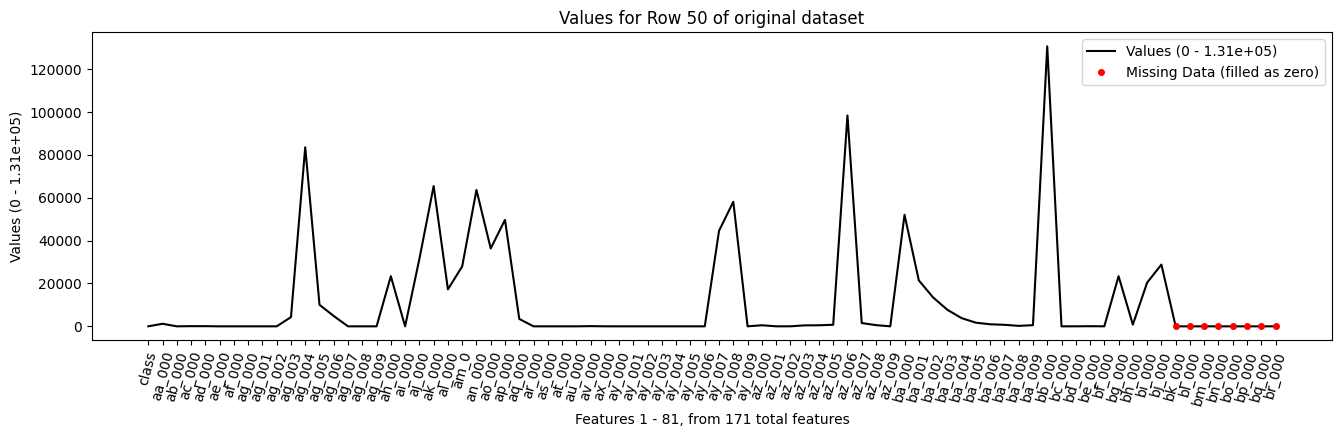

In [85]:
row_plot(df, 50, title="original dataset")

<b>Log Transformation

Some values don't show as peaks when plotting rows because the of the large range of data points. When a log transformation is used, the exponential nature of the data is revealed and multiple peaks are now shown.

In some cases, the data does seem to increase from zero and decrease back to zero in a pattern.

When the rows are plotted with a scatter plot it's tougher to say there is a pattern there, nevertheless, these plots may be useful for examining imputation of the missing data later.

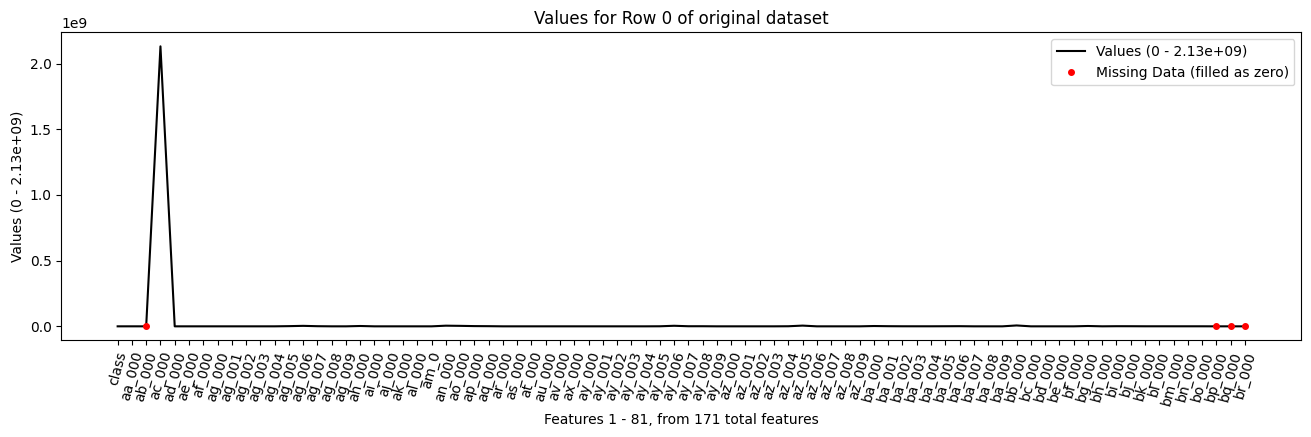

In [86]:
row_plot(df, title="original dataset")

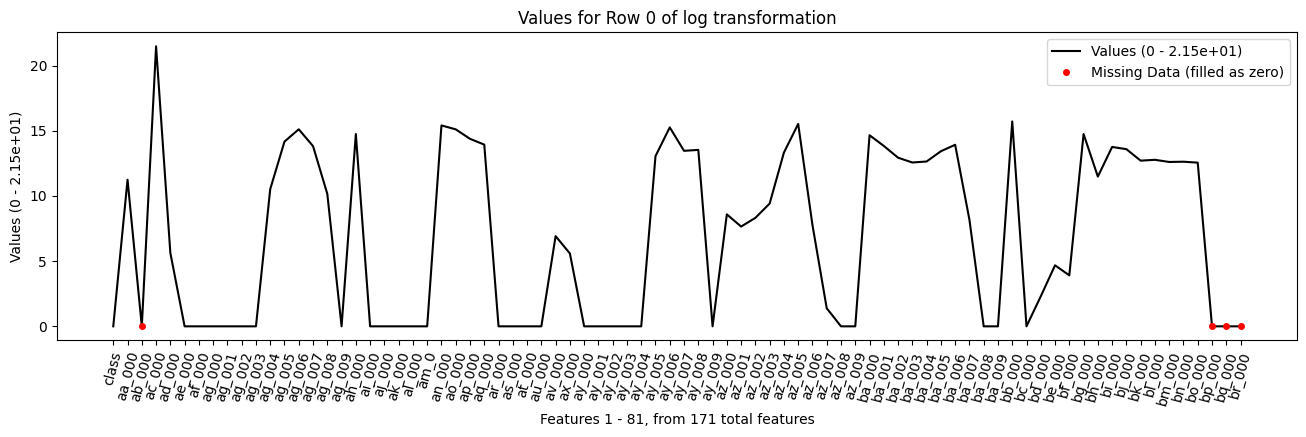

In [87]:
row_plot(df_log_transformed, title="log transformation")

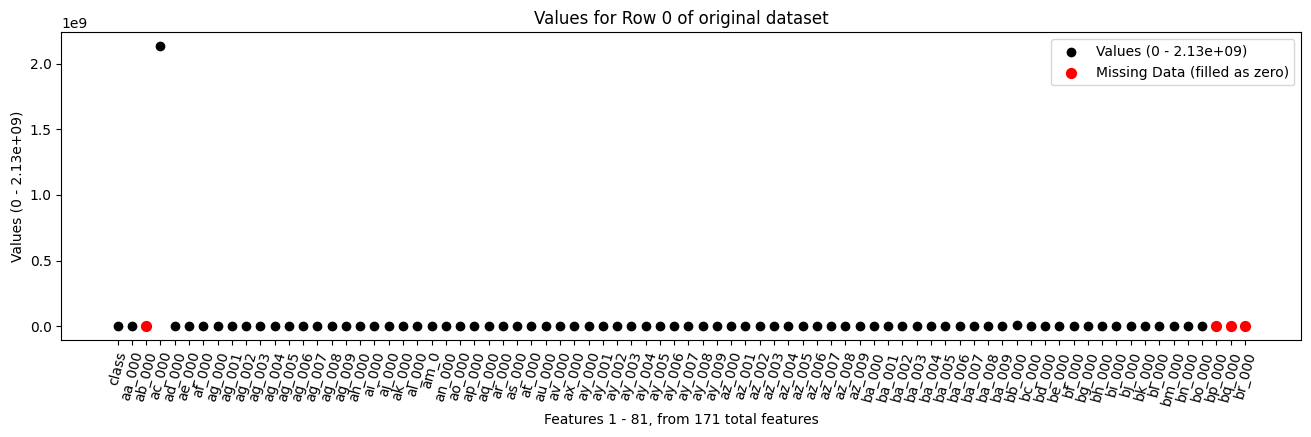

In [88]:
row_plot2(df, title="original dataset")

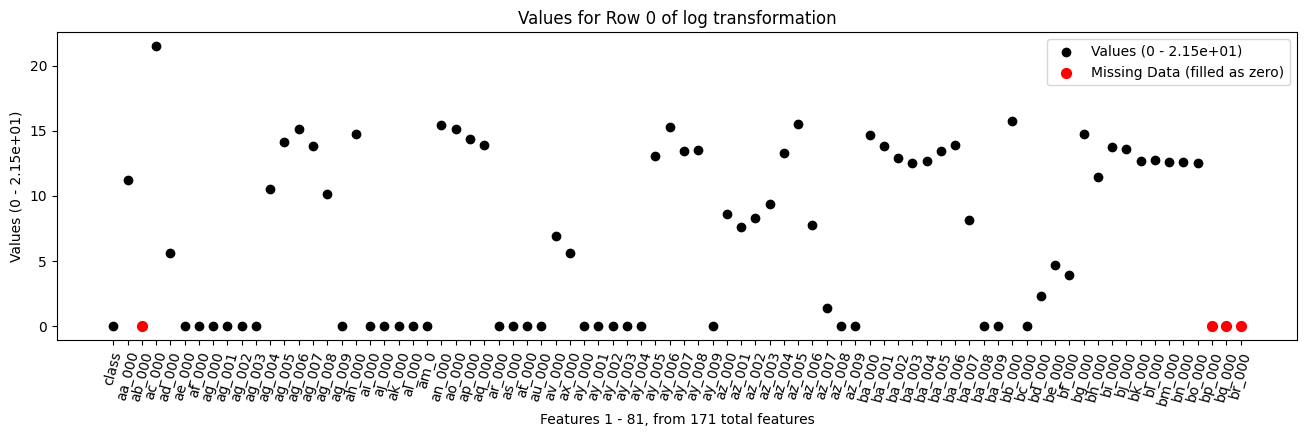

In [89]:
row_plot2(df_log_transformed, title="log transformation")

### 2.2. Imputation with Dimensionality Reduction

<b>Scaling data with PCA

Initially the the data will be imputed with the mean and examined with PCA to determine which is better holding the data variance with the least features.

L2 Normalisation, Standardisation and Min-Max Scaling are employed and compared below. L2 Normalisation holds more of the variance with less features.

Standardisation scales the data to have unit variance of the features (Müller & Guido, p. 135). Standardisation is also a good choice given that firstly, there is considerable sparce data, and secondly there are outliers. Min-Max scalar would map the outliers to 1, and *'crush'* the smaller values to low decimals (Géron, p. 76). L2 Normalisation or Euclidean normalisation (Géron, p.44), also scales the data to have unit length.

In [90]:
data = df.drop("class", axis=1)
y = df["class"]
Imputation_mean = data.fillna(data.mean())

<b>L2 Normalisation

In [91]:
scaler = Normalizer(norm='l2')
l2_normal = scaler.fit_transform(Imputation_mean)

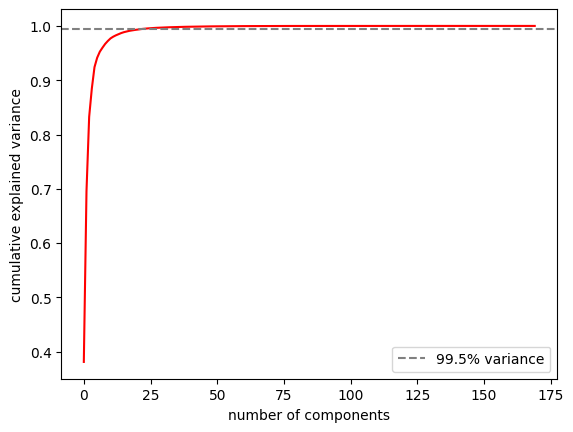

In [92]:
pca_l2_impute = PCA().fit(l2_normal) 
plt.plot(np.cumsum(pca_l2_impute.explained_variance_ratio_), color="red")
plt.axhline(y=0.995, color="grey", linestyle='--', label='99.5% variance')
plt.xlabel('number of components') 
plt.ylabel('cumulative explained variance')
plt.legend()
plt.show()

<b>Standard Scaler

In [93]:
scaler = StandardScaler()
standard_scaled = scaler.fit_transform(Imputation_mean)

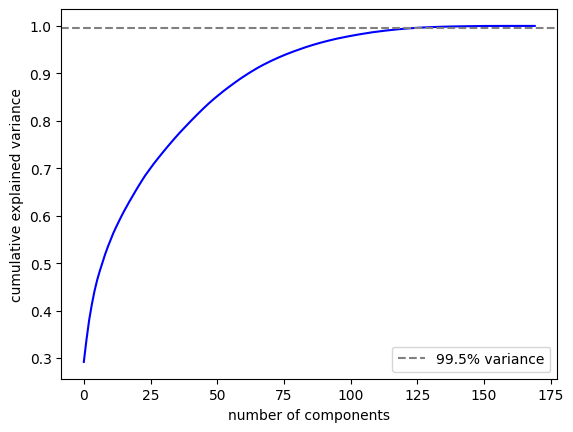

In [94]:
pca_standard_impute = PCA().fit(standard_scaled) 
plt.plot(np.cumsum(pca_standard_impute.explained_variance_ratio_), color="blue")
plt.axhline(y=0.995, color="grey", linestyle='--', label='99.5% variance')
plt.xlabel('number of components') 
plt.ylabel('cumulative explained variance')
plt.legend()
plt.show()

<b> Min Max Scaler

In [95]:
scaler = MinMaxScaler()
minmax_scaled = scaler.fit_transform(Imputation_mean)

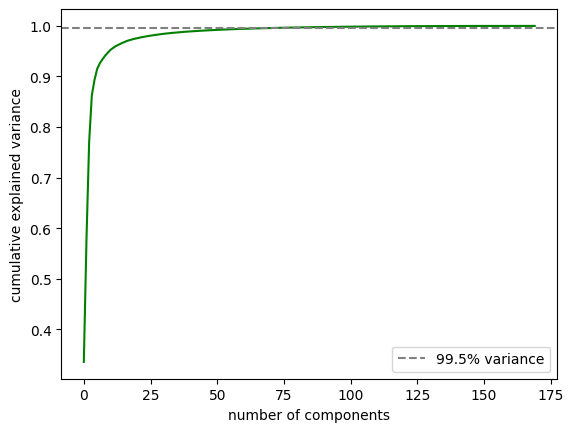

In [96]:
pca_minmax_impute = PCA().fit(minmax_scaled) 
plt.plot(np.cumsum(pca_minmax_impute.explained_variance_ratio_), color="green")
plt.axhline(y=0.995, color="grey", linestyle='--', label='99.5% variance')
plt.xlabel('number of components') 
plt.ylabel('cumulative explained variance')
plt.legend()
plt.show()

<b>Scaling Comparisson

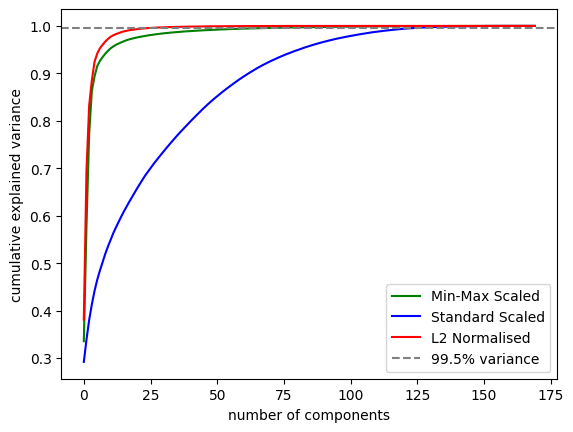

In [97]:
plt.plot(np.cumsum(pca_minmax_impute.explained_variance_ratio_), color="green", label="Min-Max Scaled")
plt.plot(np.cumsum(pca_standard_impute.explained_variance_ratio_), color="blue", label="Standard Scaled")
plt.plot(np.cumsum(pca_l2_impute.explained_variance_ratio_), color="red", label="L2 Normalised")
plt.axhline(y=0.995, color="grey", linestyle='--', label='99.5% variance')
plt.xlabel('number of components') 
plt.ylabel('cumulative explained variance')
plt.legend()
plt.show()

<b>Mean imputation with log transformation

We can examine a log transformation vs. the best fitting scaling method with PCA

With a log transformation a higher amount of components is needed to be left with 99.5% variance; 112.

In [98]:
data = df_log_transformed.drop("class", axis=1)
Imputation_mean_log = data.fillna(data.mean())

In [99]:
scaler = Normalizer(norm='l2')
mean_log_scaled = scaler.fit_transform(Imputation_mean_log)

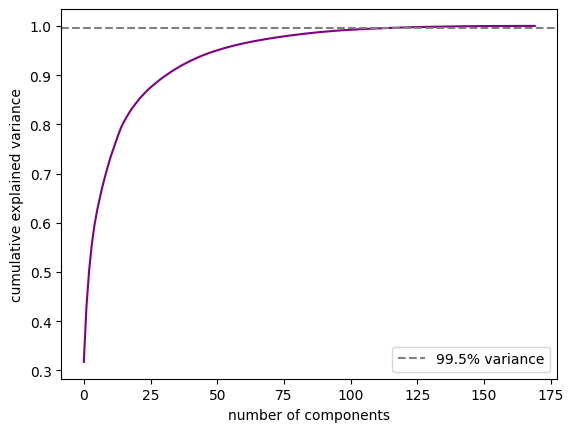

In [100]:
pca_mean_log_impute = PCA().fit(mean_log_scaled) 
plt.plot(np.cumsum(pca_mean_log_impute.explained_variance_ratio_), color="purple")
plt.axhline(y=0.995, color="grey", linestyle='--', label='99.5% variance')
plt.xlabel('number of components') 
plt.ylabel('cumulative explained variance')
plt.legend()
plt.show()

In [101]:
explained_variance = pca_mean_log_impute.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)

Explained Variance Ratios: [3.17292077e-01 1.13415888e-01 7.31634825e-02 5.26582874e-02
 3.91847633e-02 2.96584637e-02 2.51010725e-02 2.38188364e-02
 2.06878677e-02 1.95805365e-02 1.85745518e-02 1.60904666e-02
 1.55800025e-02 1.50543778e-02 1.41658582e-02 1.08272142e-02
 9.67864508e-03 9.10715471e-03 8.35784454e-03 7.25453391e-03
 6.98251003e-03 6.83935279e-03 5.90981243e-03 5.62234847e-03
 5.41723796e-03 4.99556234e-03 4.61992666e-03 4.48740925e-03
 4.42445095e-03 4.20763721e-03 3.91240012e-03 3.81189529e-03
 3.71354577e-03 3.60650424e-03 3.39770617e-03 3.31084727e-03
 3.14632050e-03 3.07320911e-03 2.88749463e-03 2.88012061e-03
 2.69507603e-03 2.53580005e-03 2.48307529e-03 2.41509046e-03
 2.29583373e-03 2.16526127e-03 2.04565955e-03 1.97524358e-03
 1.88271669e-03 1.76462042e-03 1.71081054e-03 1.68073047e-03
 1.64190273e-03 1.54470101e-03 1.53803289e-03 1.45894828e-03
 1.38498637e-03 1.32715327e-03 1.29171741e-03 1.24774576e-03
 1.18913445e-03 1.12771133e-03 1.11743735e-03 1.07978642e-

In [102]:
cumulative_variance = np.cumsum(pca_mean_log_impute.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.995) + 1
n_components

112

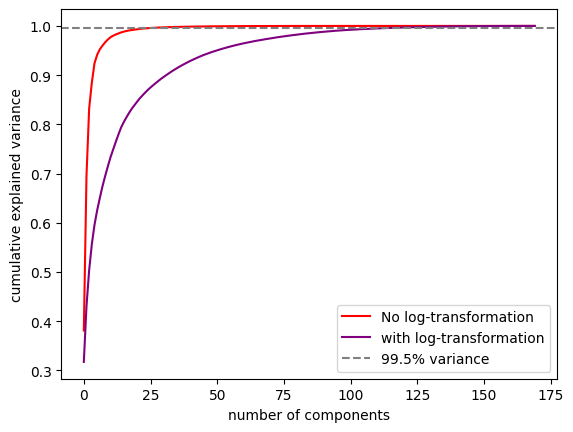

In [103]:
plt.plot(np.cumsum(pca_l2_impute.explained_variance_ratio_), color="red", label="No log-transformation")
plt.plot(np.cumsum(pca_mean_log_impute.explained_variance_ratio_), color="purple", label="with log-transformation")

plt.axhline(y=0.995, color="grey", linestyle='--', label='99.5% variance')


plt.xlabel('number of components') 
plt.ylabel('cumulative explained variance')
plt.legend()
plt.show()

<b>Imputations

Perhaps other imputations can capture the signal better. This time a pipeline will be used to imputate, scale and perform PCA.

Mean Imputation works by substituting the mean for the null values. Multi-Imputation creates a set of plausable values and produces a single estimate from these (Molenbergh et. al, p. 18). K-Nearest Neighbours Imputaton estimates missing values based on the nearest neighbours in the dataset.

In all cases they create a similar amount of features to retain 99.5% variance.

<b>Mean Imputation

In [104]:
sample = undersample(df)
X = sample.drop("class", axis=1)
y = sample["class"]

In [105]:
from sklearn.impute import SimpleImputer
pipe_mean_imputer = Pipeline([("imputer", SimpleImputer()), ("scaler", Normalizer(norm='l2')), ("pca", PCA())])
X_processed = pipe_mean_imputer.fit_transform(X)
mean_df = pd.DataFrame(data=X_processed, columns=X.columns)

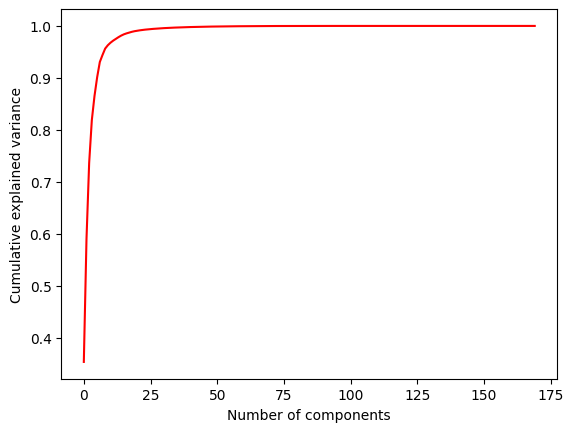

In [106]:
pca_mean_imputer = pipe_mean_imputer.named_steps['pca']
plt.plot(np.cumsum(pca_mean_imputer.explained_variance_ratio_), color="red")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

<b>KNN Imputation

In [107]:
pipe_knn_imputer = Pipeline([("imputer", KNNImputer()), ("scaler", Normalizer(norm='l2')), ("pca", PCA())])
X_knn_im_pca = pipe_knn_imputer.fit_transform(X)

In [108]:
knn_df = pd.DataFrame(data=X_knn_im_pca, columns=X.columns)

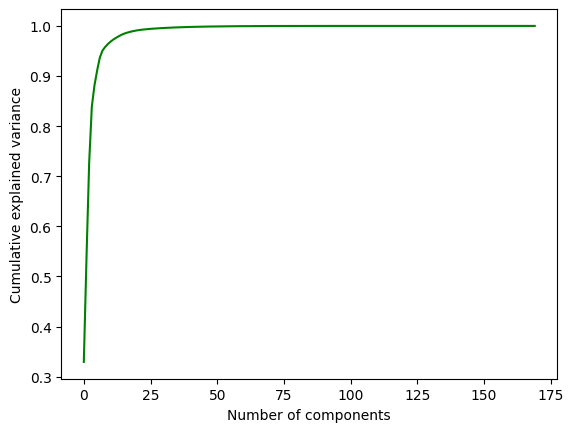

In [109]:
pca_knn_imputer = pipe_knn_imputer.named_steps['pca']
plt.plot(np.cumsum(pca_knn_imputer.explained_variance_ratio_), color="green")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

<b> Multiple Imputation

In [110]:
pipe_mi_imputer = Pipeline([("imputer", IterativeImputer(max_iter=10, random_state=0)), ("scaler", Normalizer(norm='l2')), ("pca", PCA())])
x_mi_processed = pipe_mi_imputer.fit_transform(X)
mi_df = pd.DataFrame(data=x_mi_processed, columns=X.columns)

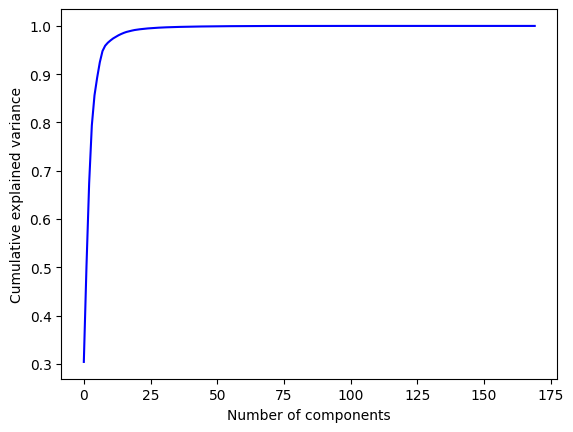

In [111]:
pca_mi_imputer = pipe_mi_imputer.named_steps['pca']
plt.plot(np.cumsum(pca_mi_imputer.explained_variance_ratio_), color="blue")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

<b>Comparing imputations with PCA

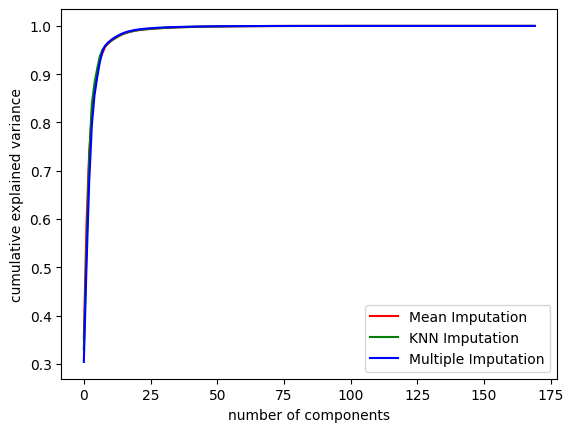

In [112]:
plt.plot(np.cumsum(pca_mean_imputer.explained_variance_ratio_), color="red", label="Mean Imputation")
plt.plot(np.cumsum(pca_knn_imputer.explained_variance_ratio_), color="green", label="KNN Imputation")
plt.plot(np.cumsum(pca_mi_imputer.explained_variance_ratio_), color="blue", label="Multiple Imputation")
plt.xlabel('number of components') 
plt.ylabel('cumulative explained variance')
plt.legend()
plt.show()

<b>Examining the imputations by row

When we look at the imputed and scaled data by row, we can see the differences that exist from the scaling due to the imputations. Although, the missing values for the examined row seem to be approximated similarly.

Title


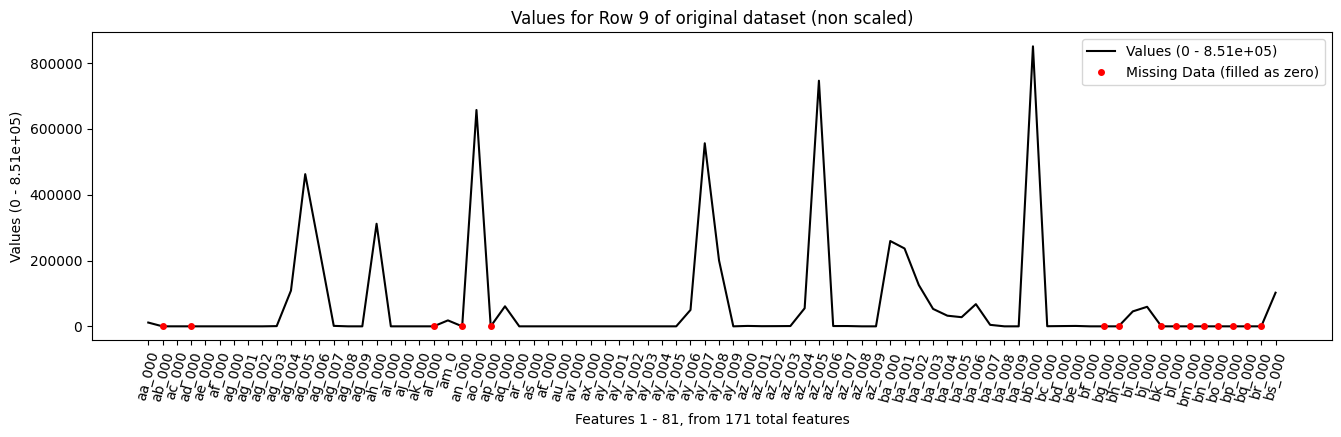

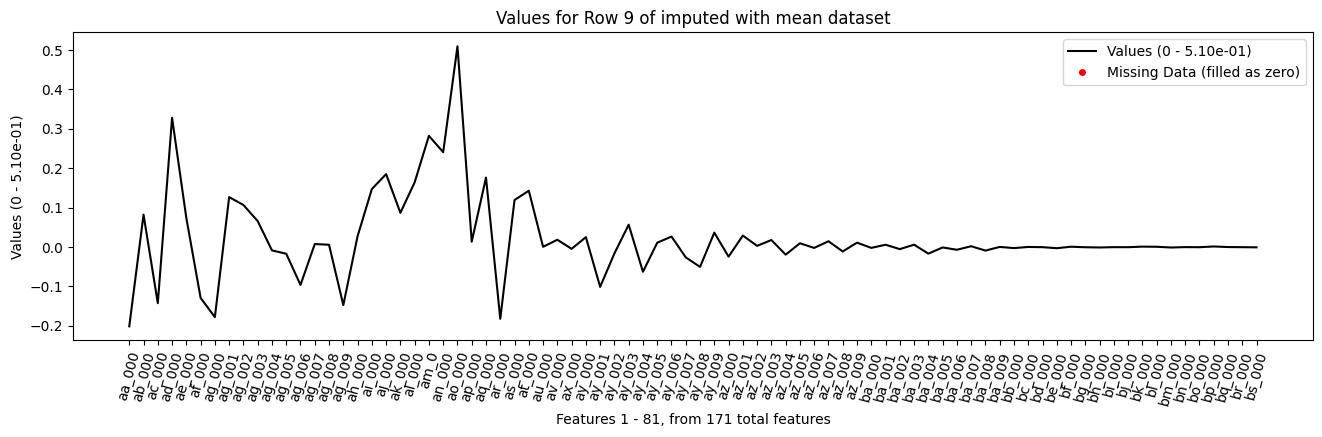

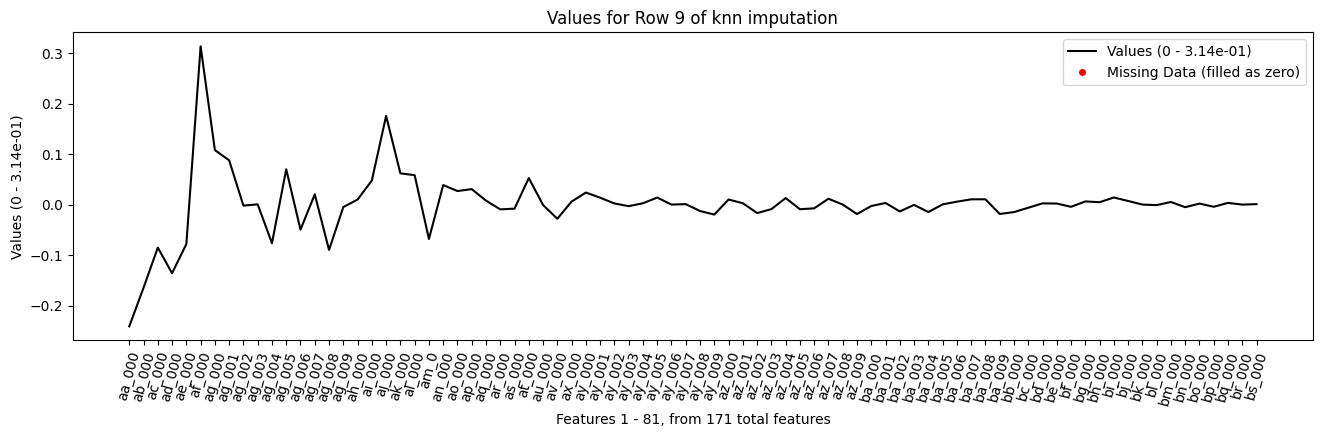

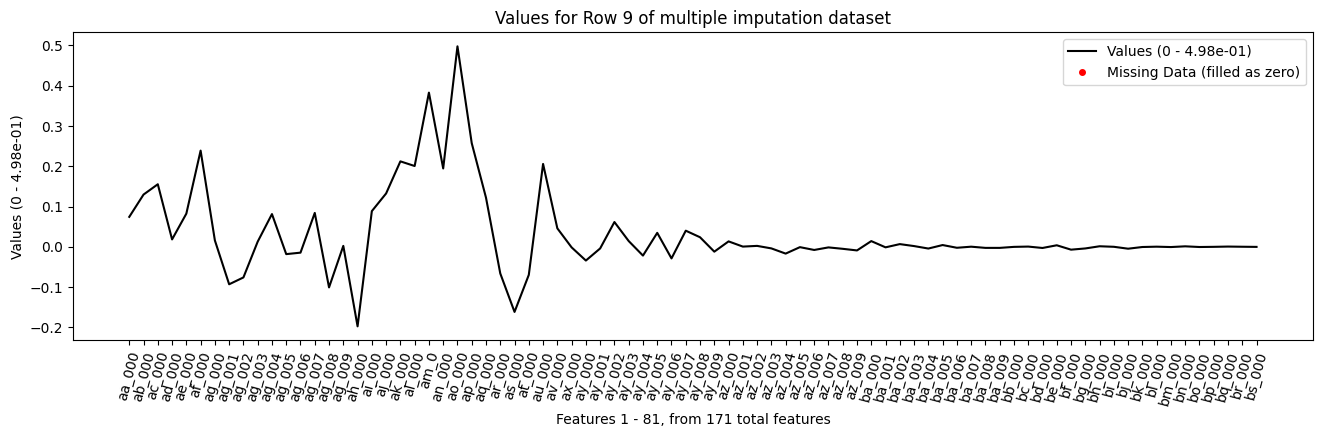

In [149]:
row = 9
print("Title")
row_plot(X, row, title="original dataset (non scaled)")
row_plot(mean_df, row, title="imputed with mean dataset")
row_plot(knn_df, row, y_start=0, y_end=80, title="knn imputation")
row_plot(mi_df, row, y_start=0, y_end=80, title="multiple imputation dataset")

### 2.3. Keeping 99.5% Variance

While the data can be imputed before splitting, it is better to imputate before to not leak information. And as the data is intended will be modeled it is split before imputation here.

Mean Imputation achieved 99.5% variance with 29 principal components.
KNN Imputation achieved 99.5% variance with 28 principal components.
Multiple Imputation achieved 99.5% variance with 25 principal components.

Although Multiple Imputation can keep the least amount of components, it won't be used for model exploration as it is computentially expensive. Instead, a simper method will be used to trial models, given that the imputation methods are all similarly performing.

<b>Train Test split

In [114]:
y_model = sample["class"]
X_model = sample.drop("class", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=118)

<b> Mean Imputation

In [115]:
# seperate pipelines 
pipe1 = Pipeline([("imputer", SimpleImputer(strategy='mean')), ("scaler", Normalizer(norm='l2'))])
pipe2 = Pipeline([("imputer", SimpleImputer(strategy='mean')), ("scaler", Normalizer(norm='l2'))])

X_train_processed_mean = pipe1.fit_transform(X_train)
X_test_processed_mean = pipe2.fit_transform(X_test)

# pca 99.5% variance
pca = PCA(n_components=0.995)

# same transformation on train and test
X_train_processed = pca.fit_transform(X_train_processed_mean)
X_test_processed = pca.transform(X_test_processed_mean)

print(f"Number of principal components needed for 99.5% variance with mean imputation: {pca.n_components_}")

Number of principal components needed for 99.5% variance with mean imputation: 29


<b> KNN Imputer

In [116]:
# seperate pipelines 
pipe1 = Pipeline([("imputer", KNNImputer()), ("scaler", Normalizer(norm='l2'))])
pipe2 = Pipeline([("imputer", KNNImputer()), ("scaler", Normalizer(norm='l2'))])

X_train_processed_knn = pipe1.fit_transform(X_train)
X_test_processed_knn = pipe2.fit_transform(X_test)

# pca 99.5% variance
pca = PCA(n_components=0.995)

# same transformation on train and test
X_train_processed = pca.fit_transform(X_train_processed_knn)
X_test_processed = pca.transform(X_test_processed_knn)

print(f"Number of principal components needed for 99.5% variance with KNN imputation: {pca.n_components_}")

Number of principal components needed for 99.5% variance with KNN imputation: 28


<b> Multiple Imputation

In [117]:
# seperate pipelines 
pipe1 = Pipeline([("imputer", IterativeImputer(max_iter=5, random_state=0)), ("scaler", Normalizer(norm='l2'))])
pipe2 = Pipeline([("imputer", IterativeImputer(max_iter=5, random_state=0)), ("scaler", Normalizer(norm='l2'))])

X_train_processed_mi = pipe1.fit_transform(X_train)
X_test_processed_mi = pipe2.fit_transform(X_test)

# pca 99.5% variance
pca = PCA(n_components=0.995)

# same transformation on train and test
X_train_processed = pca.fit_transform(X_train_processed_mi)
X_test_processed = pca.transform(X_test_processed_mi)

print(f"Number of principal components needed for 99.5% variance with multiple imputation: {pca.n_components_}")

Number of principal components needed for 99.5% variance with multiple imputation: 25


### 2.4. Classification

Now that the data has been dimensionality reduced it can be modelled. First some machine learning models will be run on the data, which shows that the data can be modelled effectively. The dummy classifier is used to see if our models can perform better than random chance.

The machine learning models below show promising results, some of them will be examined more closely.

<b>Dummy Classifier

In [118]:
model = DummyClassifier(strategy="most_frequent")

model.fit(X_train_processed_mean, y_train)
predictions = model.predict(X_test_processed_mean)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.4975


<b>Logistic regression

In [119]:
model = LogisticRegression()

model.fit(X_train_processed_mean, y_train)
predictions = model.predict(X_test_processed_mean)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9025


<b>K Neighbours 

In [120]:
model = KNeighborsClassifier()

model.fit(X_train_processed_mean, y_train)
predictions = model.predict(X_test_processed_mean)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.89


<b> Decision Tree

In [121]:
model = DecisionTreeClassifier(max_depth=10)

model.fit(X_train_processed_mean, y_train)
predictions = model.predict(X_test_processed_mean)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.91


<b> Gaussian Naive Bayes

In [122]:
model = GaussianNB()

model.fit(X_train_processed_mean, y_train)
predictions = model.predict(X_test_processed_mean)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8


<b>Support Vector Classifier

In [123]:
model = SVC()

model.fit(X_train_processed_mean, y_train)
predictions = model.predict(X_test_processed_mean)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9125


<b>Cross validation

Cross validation is used now to examine some of the better performing models and see how well they generalise. Removing the "luck" from chosing a favourable split to train our models on (Muller & Guido, p. 260).

In the three cases below they generalise well, and are accurate, but below more details of the models will be explored.

<b>Logistic regression cross validation 

In [124]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', Normalizer(norm='l2')),
    ('classifier', LogisticRegression())
])


cv_scores = cross_val_score(pipeline, X_model, y_model, cv=5, scoring='accuracy')


print("Cross-validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-validation Scores: [0.93   0.9175 0.9175 0.93   0.915 ]
Mean Accuracy: 0.922


<b>Decision tree cross validation 

In [125]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', Normalizer(norm='l2')),
    ('classifier', DecisionTreeClassifier(max_depth=10))
])


cv_scores = cross_val_score(pipeline, X_model, y_model, cv=5, scoring='accuracy')

print("Cross-validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-validation Scores: [0.9375 0.9175 0.9325 0.9225 0.905 ]
Mean Accuracy: 0.923


<b>Support Vector Machine cross validation 

In [126]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', Normalizer(norm='l2')), 
    ('classifier', SVC()) 
])


cv_scores = cross_val_score(pipeline, X_model, y_model, cv=5, scoring='accuracy')

print("Cross-validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-validation Scores: [0.955  0.925  0.925  0.945  0.9225]
Mean Accuracy: 0.9344999999999999


<b>Classification Reports, Confusion Matrix and ROC

Again we can get more information on how the models perform by producing a classification report.

The confusion matrix show that the models are slightly more accurate at predicting the negative class (this information is also in the classification report).

The ROC plots are interesting as although the three models investigated seemed to perform similarly, the area under the curve is slightly less on the decision tree.

<b>Logistic Regression Classificaiton Report & Confusion Matrix

In [127]:
lr_classifier = LogisticRegression()

lr_classifier.fit(X_train_processed_mean, y_train)
predictions_lr = lr_classifier.predict(X_test_processed_mean)

accuracy_lr = accuracy_score(y_test, predictions_lr)
report_lr = classification_report(y_test, predictions_lr)

print("KNN Classifier Accuracy:", accuracy_lr)
print("KNN Classifier Classification Report:")
print(report_lr)

KNN Classifier Accuracy: 0.9025
KNN Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       201
           1       0.86      0.96      0.91       199

    accuracy                           0.90       400
   macro avg       0.91      0.90      0.90       400
weighted avg       0.91      0.90      0.90       400



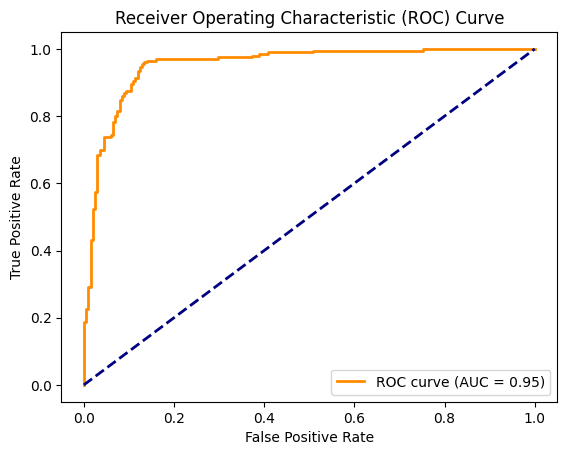

In [143]:
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train_processed_mean, y_train)

y_probs = clf.predict_proba(X_test_processed_mean)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

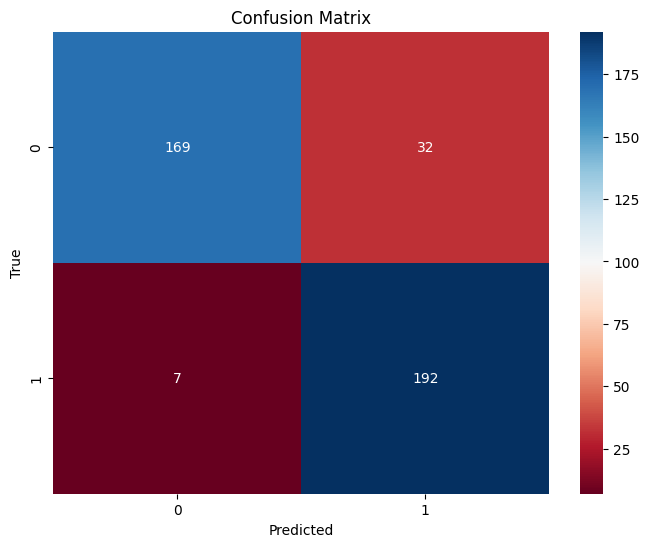

In [128]:
plot_confusion_matrix(y_test, predictions_lr)

<b>Decision Tree Classificaiton Report & Confusion Matrix

In [129]:
dt_classifier = DecisionTreeClassifier(max_depth=10)

dt_classifier.fit(X_train_processed_mean, y_train)
predictions_dt = dt_classifier.predict(X_test_processed_mean)

accuracy_dt = accuracy_score(y_test, predictions_dt)
report_dt = classification_report(y_test, predictions_dt)

print("Decision Tree Classifier Accuracy:", accuracy_dt)
print("Decision Tree Classifier Classification Report:")
print(report_dt)

Decision Tree Classifier Accuracy: 0.915
Decision Tree Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       201
           1       0.89      0.94      0.92       199

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.91       400
weighted avg       0.92      0.92      0.91       400



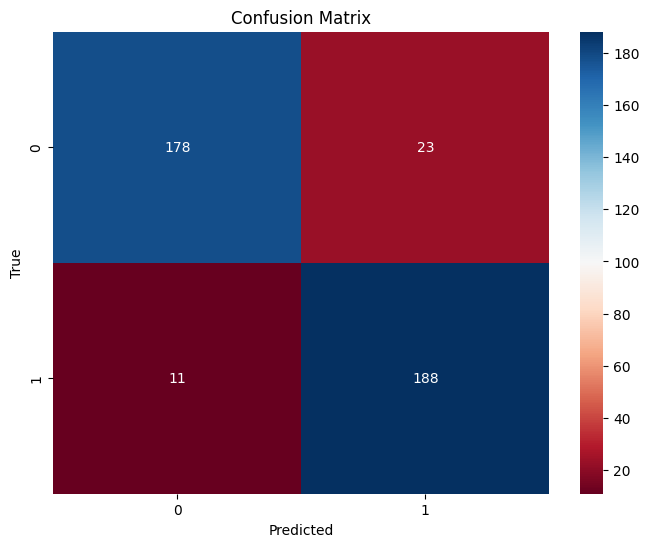

In [130]:
plot_confusion_matrix(y_test, predictions_dt)

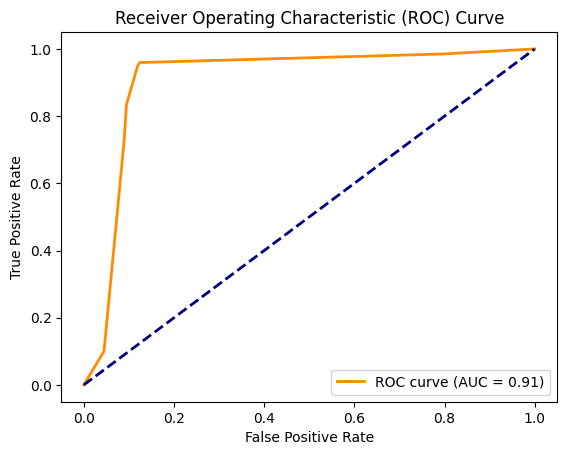

In [144]:
clf = DecisionTreeClassifier(max_depth=10) 
clf.fit(X_train_processed_mean, y_train)


y_probs = clf.predict_proba(X_test_processed_mean)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<b>Support Vector Machine Classificaiton Report & Confusion Matrix

In [132]:
svm_classifier = SVC()

svm_classifier.fit(X_train_processed_mean, y_train)
predictions_svm = svm_classifier.predict(X_test_processed_mean)

accuracy_svm = accuracy_score(y_test, predictions_svm)
report_svm = classification_report(y_test, predictions_svm)

print("SVM Classifier Accuracy:", accuracy_svm)
print("SVM Classifier Classification Report:")
print(report_svm)

SVM Classifier Accuracy: 0.9125
SVM Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       201
           1       0.87      0.97      0.92       199

    accuracy                           0.91       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.92      0.91      0.91       400



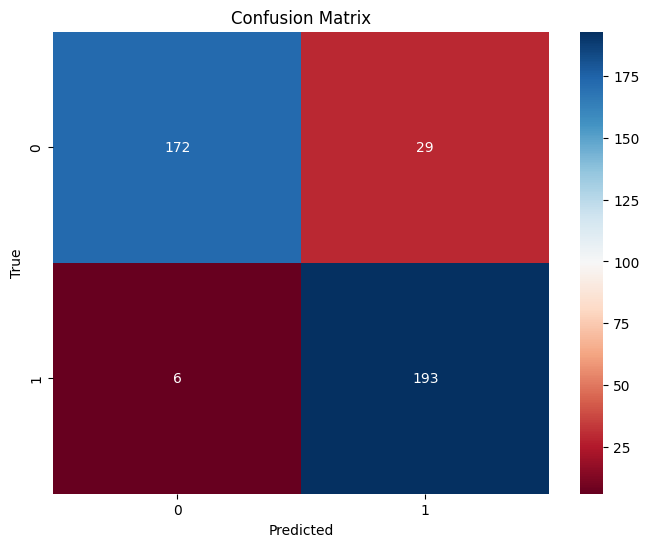

In [133]:
plot_confusion_matrix(y_test, predictions_svm)

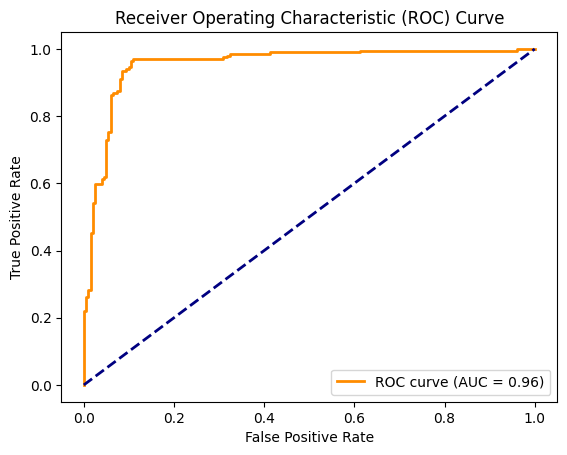

In [140]:
from sklearn.metrics import roc_curve, roc_auc_score
clf = SVC(probability=True) 
clf.fit(X_train_processed_mean, y_train)


y_probs = clf.predict_proba(X_test_processed_mean)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 2.5. Most Important Features

As the data can be accurately modelled we can look at which features are important to the data. Previously Logistic regression was employed to model the data, by default it uses a L2 penalty to reduce the importance of coefficients (the same eucledian distance as in L2 normalisation).

The strength of this reguralisation can be controlled.

This gives an overview of what features are important to the Logistic Regression model, without PCA applied. Although, PCA employs a different method to "select" features and we only achieve an indication of what may be important to PCA here.

In [134]:
pipeline3 = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaling', StandardScaler()),
    ('classifier', LogisticRegression())
])
param_grid = {
    "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ["l1", "l2", "elasticnet"]
}


grid_search = GridSearchCV(pipeline3, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('imputer', SimpleImputer()), ('scaling', StandardScaler()),
                ('classifier', LogisticRegression(C=1))])

In [135]:
print("Best Model Accuracy:", grid_search.best_score_)
print("Best classifier__penalty:", grid_search.best_params_["classifier__penalty"])
print("Best classifier__C:", grid_search.best_params_["classifier__C"])

Best Model Accuracy: 0.9380000000000001
Best classifier__penalty: l2
Best classifier__C: 1


In [136]:
logistic_regression_model = best_model.named_steps['classifier']


coefficients = logistic_regression_model.coef_[0]
feature_names = X.columns

for coef, feat in zip(coefficients, feature_names):
    value_from_missing_counts = missing_counts.loc[feat, 'percent_missing']
    print(f"Feature: {feat}, Coefficient: {coef}, {round(value_from_missing_counts, 2)}% null")

Feature: aa_000, Coefficient: 1.1239176343541153, 0.0% null
Feature: ab_000, Coefficient: 0.1158625095400186, 77.22% null
Feature: ac_000, Coefficient: 0.3264524057791164, 5.56% null
Feature: ad_000, Coefficient: -0.4646021614063746, 24.77% null
Feature: ae_000, Coefficient: -0.025123671967945675, 4.17% null
Feature: af_000, Coefficient: -0.20022052567182796, 4.17% null
Feature: ag_000, Coefficient: 0.06363872796547598, 1.12% null
Feature: ag_001, Coefficient: -0.21230052851258824, 1.12% null
Feature: ag_002, Coefficient: 0.550136988178037, 1.12% null
Feature: ag_003, Coefficient: 0.4719584394525254, 1.12% null
Feature: ag_004, Coefficient: 0.31599154666291757, 1.12% null
Feature: ag_005, Coefficient: -0.32299212232449603, 1.12% null
Feature: ag_006, Coefficient: 0.1302060789827261, 1.12% null
Feature: ag_007, Coefficient: -0.3122545781698592, 1.12% null
Feature: ag_008, Coefficient: 0.1683578224552336, 1.12% null
Feature: ag_009, Coefficient: -0.11650245528127492, 1.12% null
Feature: 

## 3. Conclusion

In each case 99.5% variance has been kept, but this does include noise added from imputation, and possibly some information loss from dimensionality reduction. 

Overall each imputation method performed similar, with Multiple Imputation achieving 99.5% variance with the least principal components.

On standardisation, l2 was the most performing method. While normalisation and using a log transformation did not produce good results.

Cross Validation was performed with a few models; logistic regression, decision tree, and support vector machine. This showed positive results and after our data preparation the models could generalise well on the data.

Further exploration of the models showed that decision tree performed a bit worse as the area under the curve in the ROC curve was less than the other two models. Based on this, if a grid search was to be employed and a model refined then logistic regression or support vector machine would be a good candidate.

<b>References

Burkov, A. (2019) *The Hundred-Page Machine Learning Book* published by Andriy Burkov

Géron, A. (2022) *Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow* Sebastopol: O'Reilly Media, Inc.

Harrison, M. (2019) *Machine Learning Pocket Reference* Sebastopol: O'Reilly Media, Inc.

Müller & Guido (2019) *Introduction to Machine Learning with Python* Sebastopol: O'Reilly Media, Inc.

Molenberghs et. al (2015) *Handbook of Missing Data Methodology* Boca Raton: Taylor & Francis Grouop

Provost & Fawcett (2013) *Data Science for Business* Sebastopol: O'Reilly Media, Inc.

Rowntree, D. (2018) *Statistics without Tears: An Introduction for Non-Mathematicians.* Great Britain: Penguin Books

Spiegelhalter, D. (2019) *The Art of Statistics: Learning from Data.* Great Britain: Penguin Books

Upton & Cook (2014) *A Dictionary of Statistics.* United Kingdom: Oxford University Press